In [1]:
import numpy as np
from numba import jit
from numpy.random import default_rng as rg
rng = rg(12345)
from tqdm import tqdm
import sys
sys.path.append('../core')
%matplotlib inline

In [2]:
import torch
torch.manual_seed(0)
import torch.optim as optim

In [3]:
from FLDojo import dojo
from FL import FL
from DNN_R import DNN
from display2 import*

205.826229518


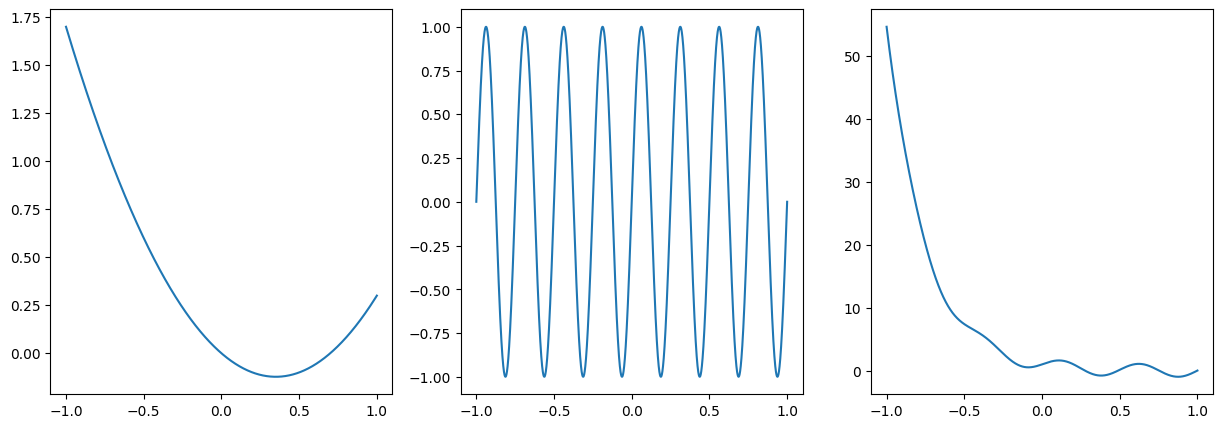

In [4]:
Xs = np.linspace(-1,1,40000)
Ys0 = Xs**2 - 0.7*Xs
# derivative is 2x - 0.7, which has a absval max of 2.7 (which is the Lipshitz constant)
Ys1 = np.sin(Xs*8*np.pi)
# note derivative is 8 pi cos(8 pi x), which has a max of 8 pi (which is the Lipshitz constant)
Ys2 = np.sin(Xs*4*np.pi) + np.exp(-4*Xs)
print(np.max(np.abs(4*np.pi*np.cos(4*np.pi*Xs) - 4*np.exp(-4*Xs))))
# derivative has a max of ~205 (which is the Lipshitz constant)
from matplotlib import pyplot as plt
fig,axs = plt.subplots(1,3,figsize=(15,5))
axs[0].plot(Xs,Ys0)
axs[1].plot(Xs,Ys1)
axs[2].plot(Xs,Ys2)

# We will use the same network for all three functions
ks = [2.7,8*np.pi,205]
dnn_sizes = [1,102,101,1] # so # of weights is 102*1 + 102*102 + 102*1 = 10608  
fl_sizes = [1,100,100] # so # of weights is  1*a + a*1 + a*a + a*1 = 10300, for a = 100

fl_sizes2 = [1,25,25] # so # of weights is  1*a + a*1 + a*a + a*1 = 700, for a = 25
dnn_sizes2 = [1,26,26,1] # so # of weights is 26*1 + 26*26 + 26*1 = 728
# a three layer nn can represent any multivariate function (continuous or discontinuous) https://arxiv.org/abs/2012.03016


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
p = np.random.permutation(len(Xs))
Xs = Xs[p]
X = torch.from_numpy(Xs).float().unsqueeze(1).to(device)
split = 0.75
train_X = X[:int(split*len(X))]
test_X = X[int(split*len(X)):]

def update_y(Ys):
    y = torch.from_numpy(Ys[p]).float().unsqueeze(1).to(device)
    train_y = y[:int(split*len(y))]
    test_y = y[int(split*len(y)):]
    return train_y, test_y
train_y,test_y = update_y(Ys0)

In [6]:
D = dojo()
D.epochs=1000
D.max_batch_size=train_X.shape[0]
opt = lambda x: optim.Adam(x, lr=0.00001) # Adam better than SGD and AdamW in quick tests.

# Function 0

## DNN 0

100%|██████████| 1000/1000 [00:12<00:00, 81.81it/s]


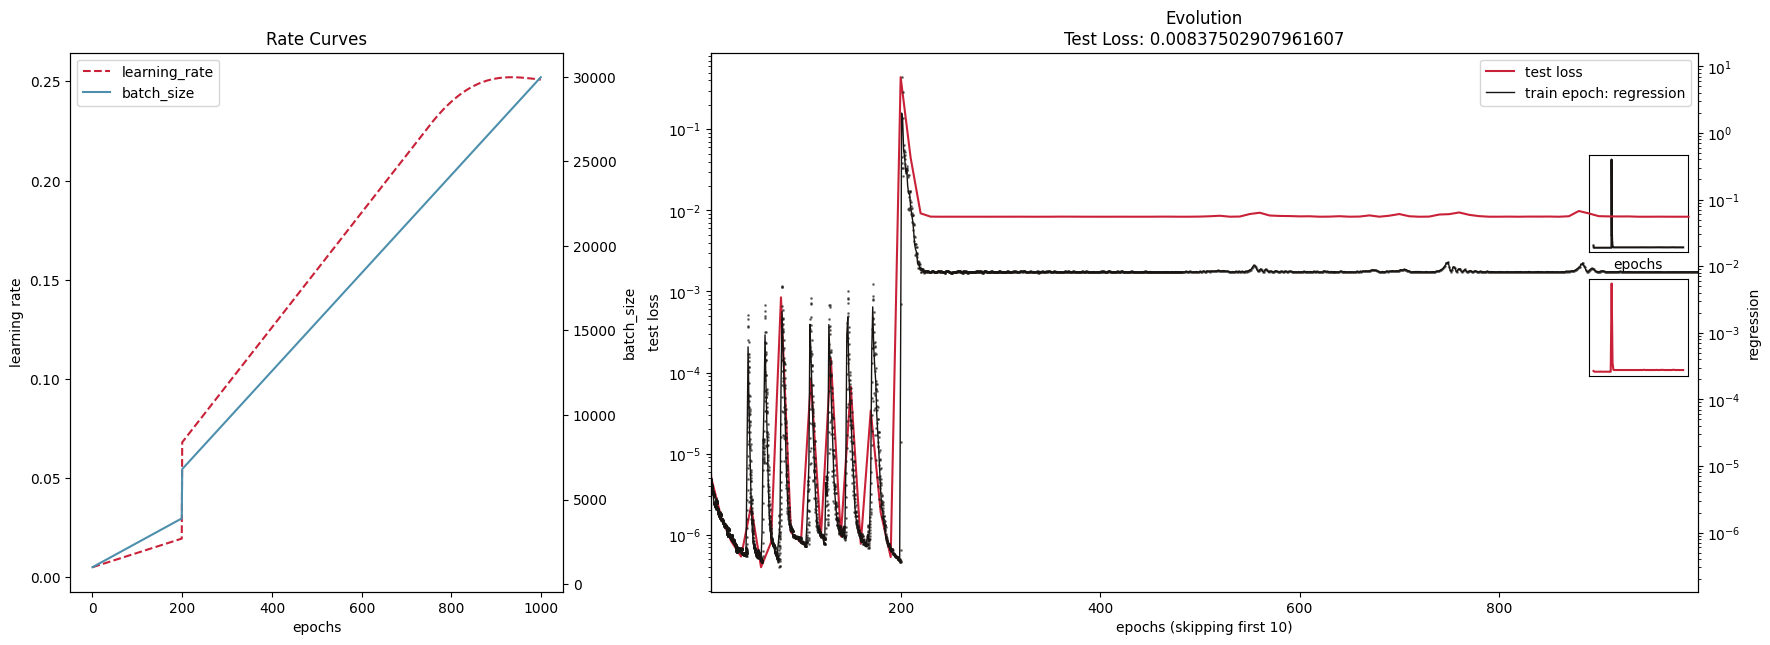

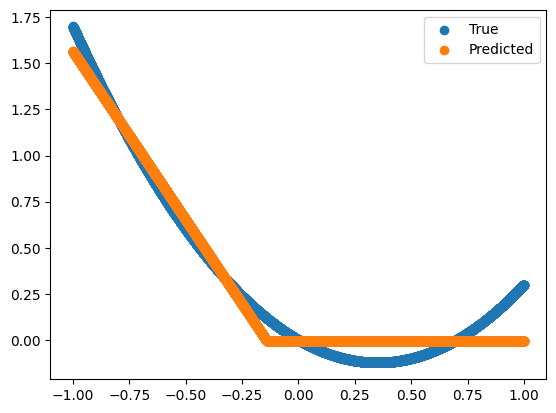

In [7]:
act = torch.nn.ReLU()
net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:34<00:00, 29.24it/s]


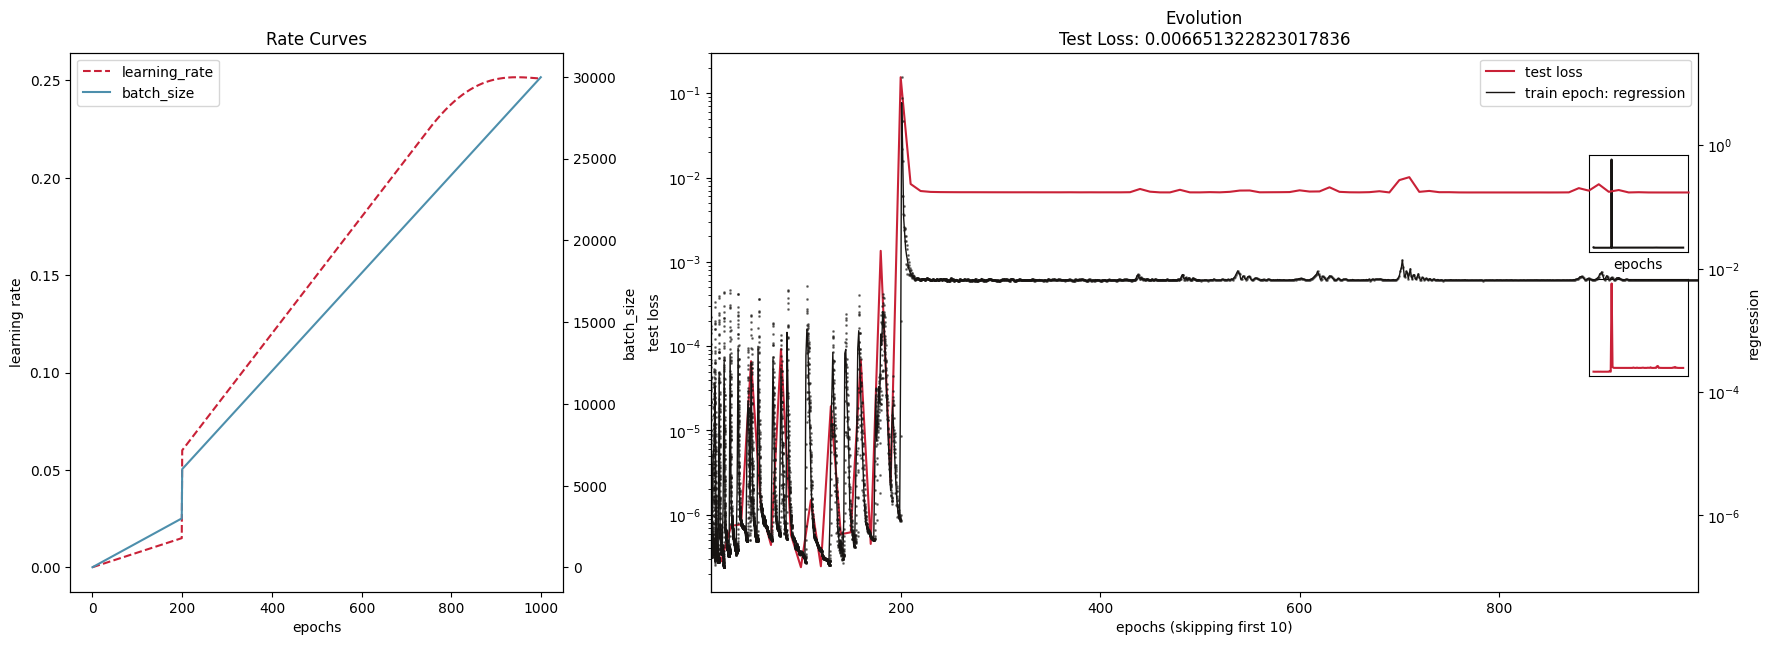

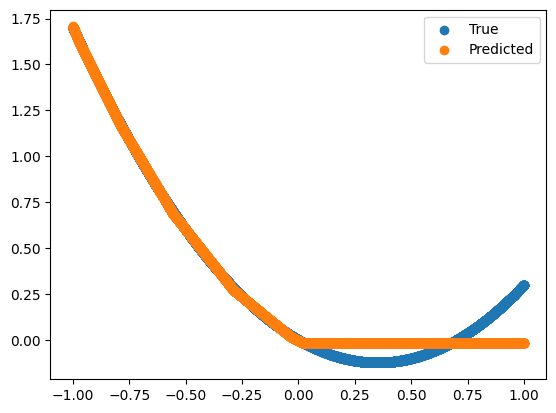

In [8]:
act = torch.nn.ReLU()
net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:23<00:00, 42.29it/s]


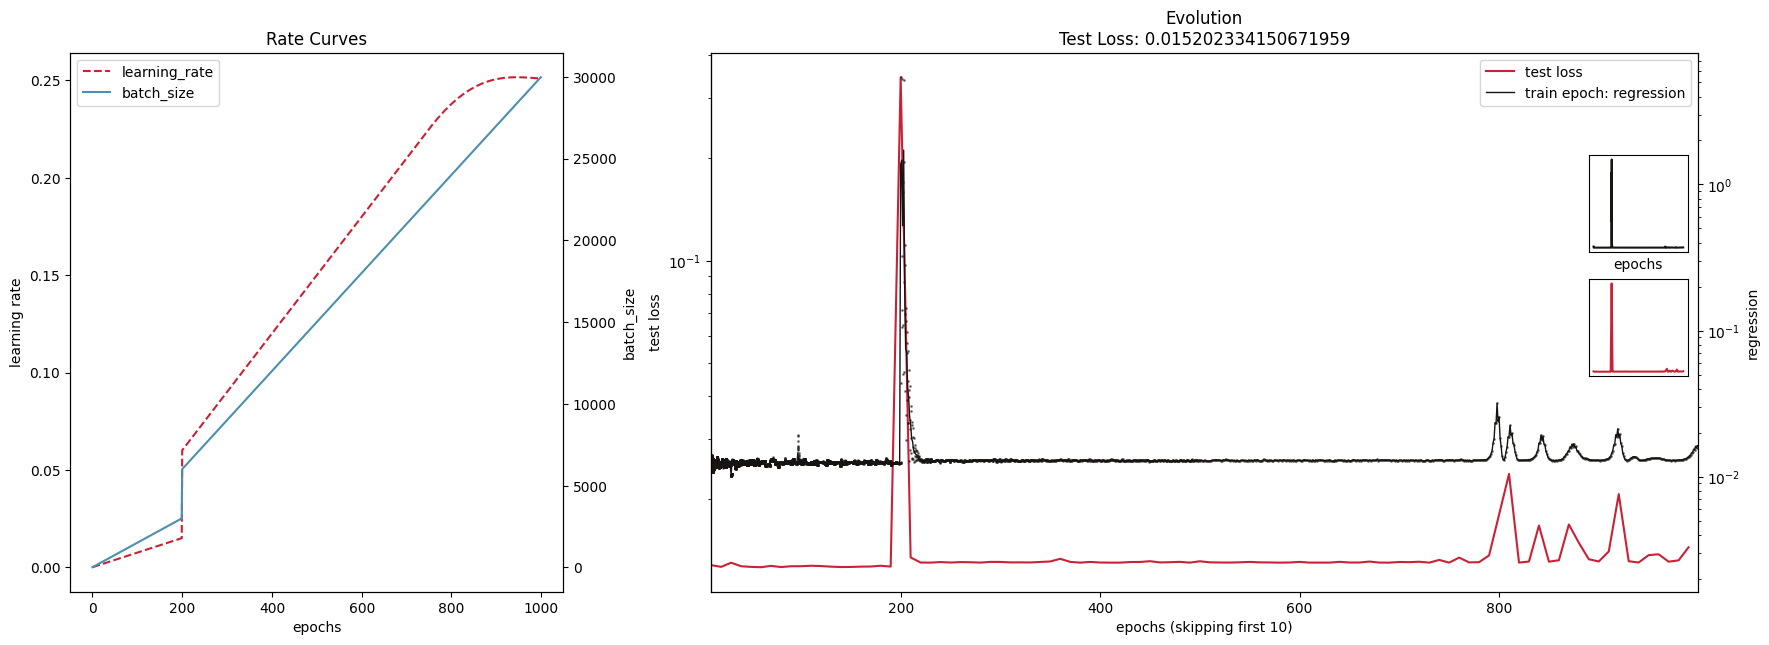

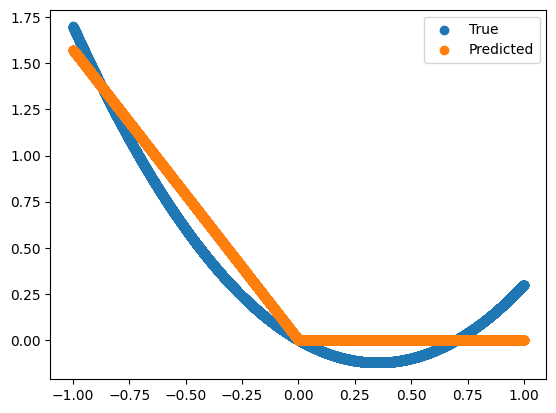

In [9]:
act = torch.nn.ReLU()
net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=False) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:37<00:00, 26.85it/s]


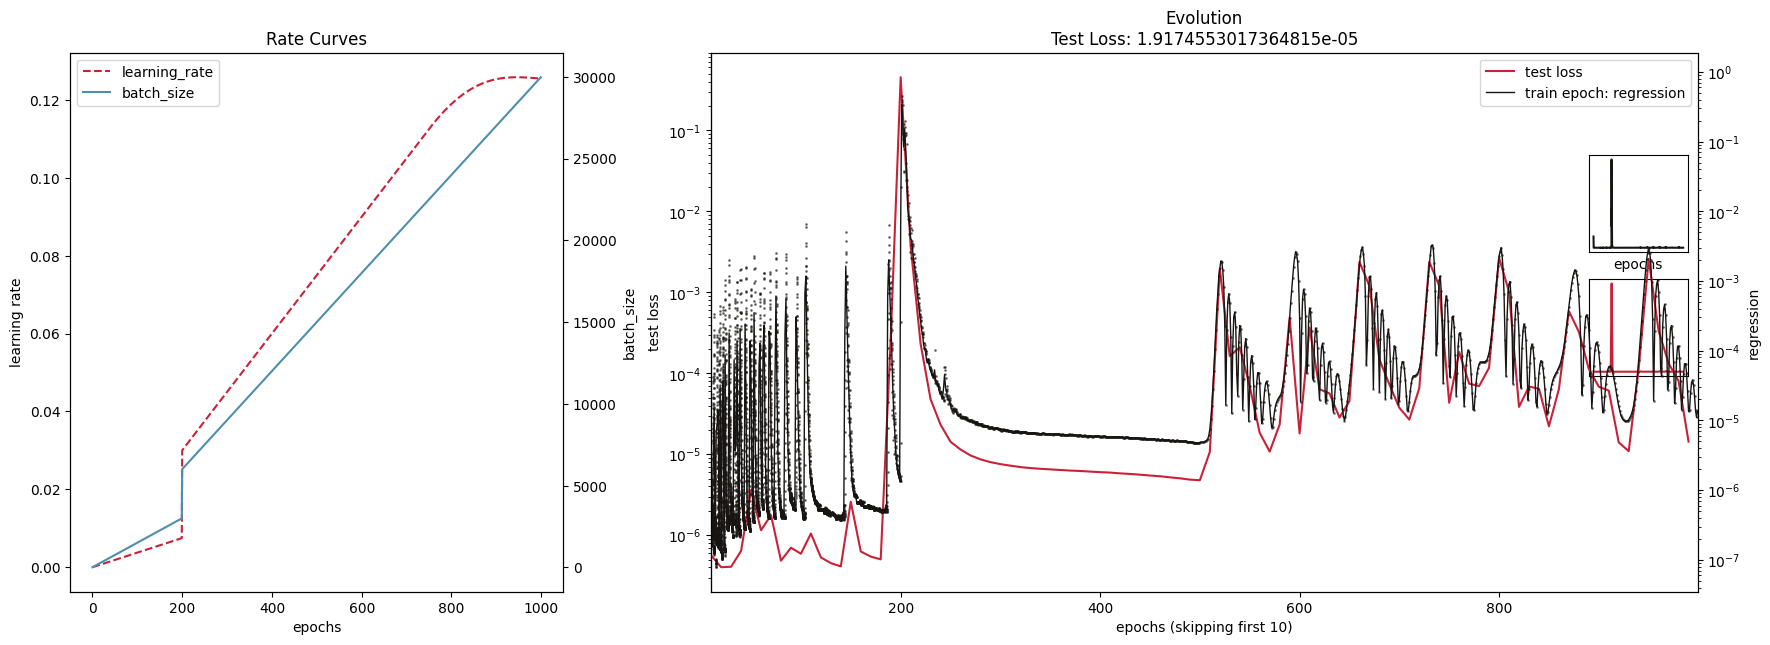

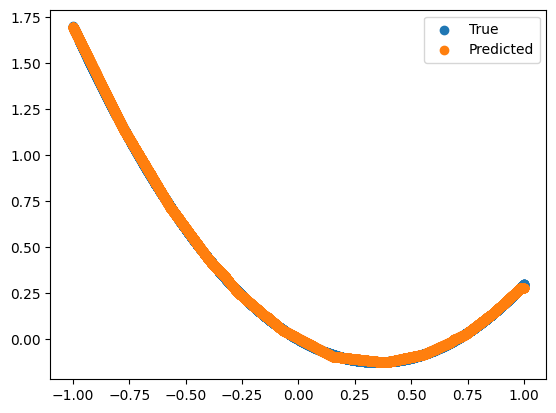

In [10]:
act = torch.nn.ReLU()
opt2 = lambda x: optim.Adam(x, lr=0.000005)
net = DNN(device, dnn_sizes, opttype=opt2, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10, max_batch_size=100)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

## FL 0

100%|██████████| 1000/1000 [00:45<00:00, 22.14it/s]


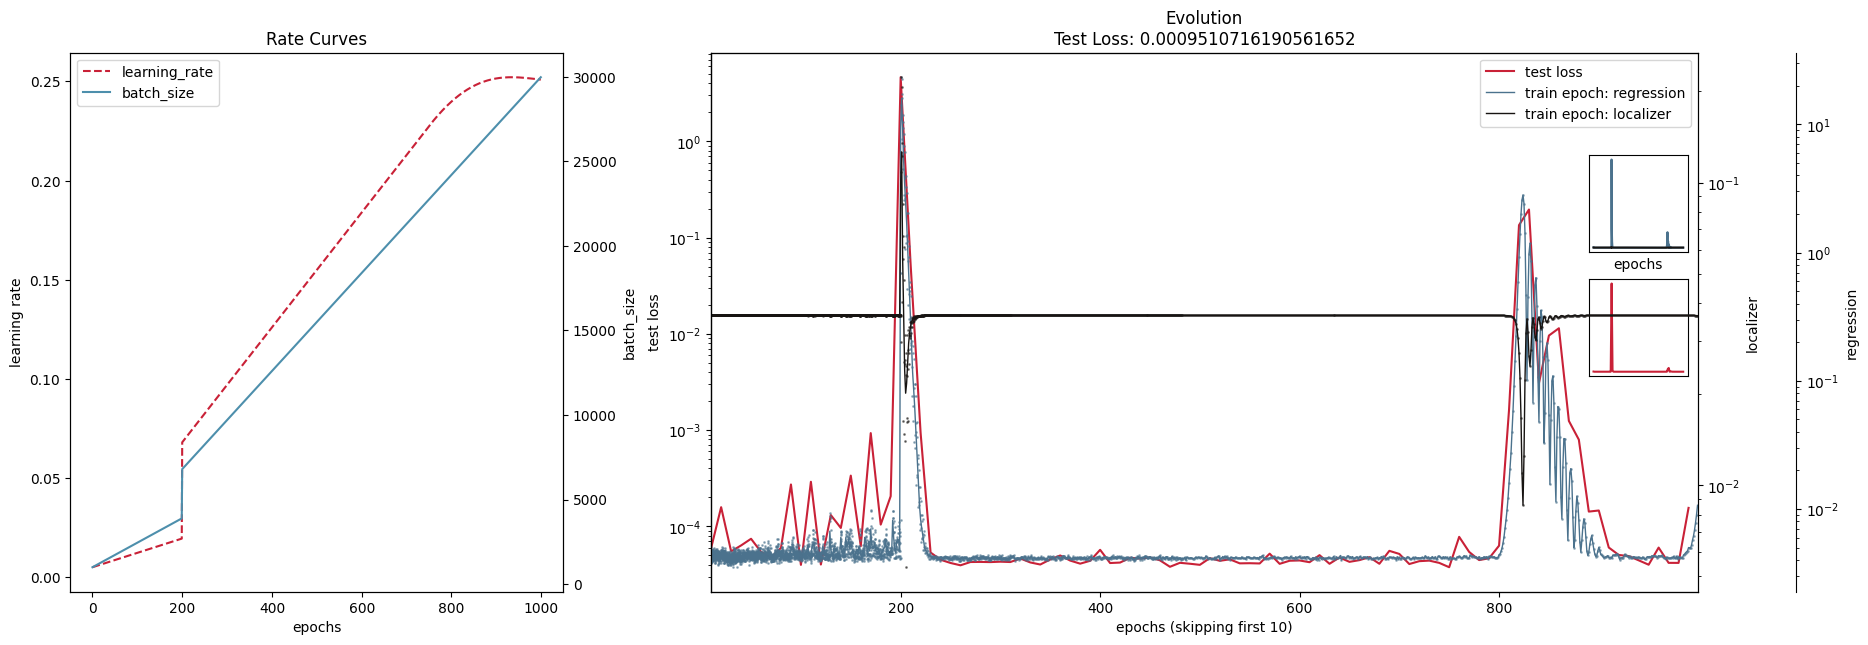

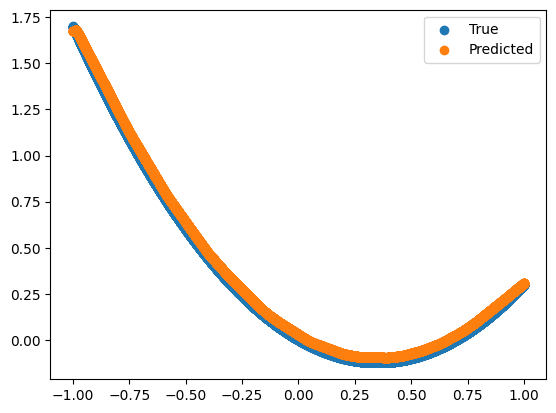

In [11]:
delta = np.array([1]*len(fl_sizes))*0.05
k = [ks[0]]*len(fl_sizes)
act = torch.nn.ReLU()
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:43<00:00, 23.22it/s]


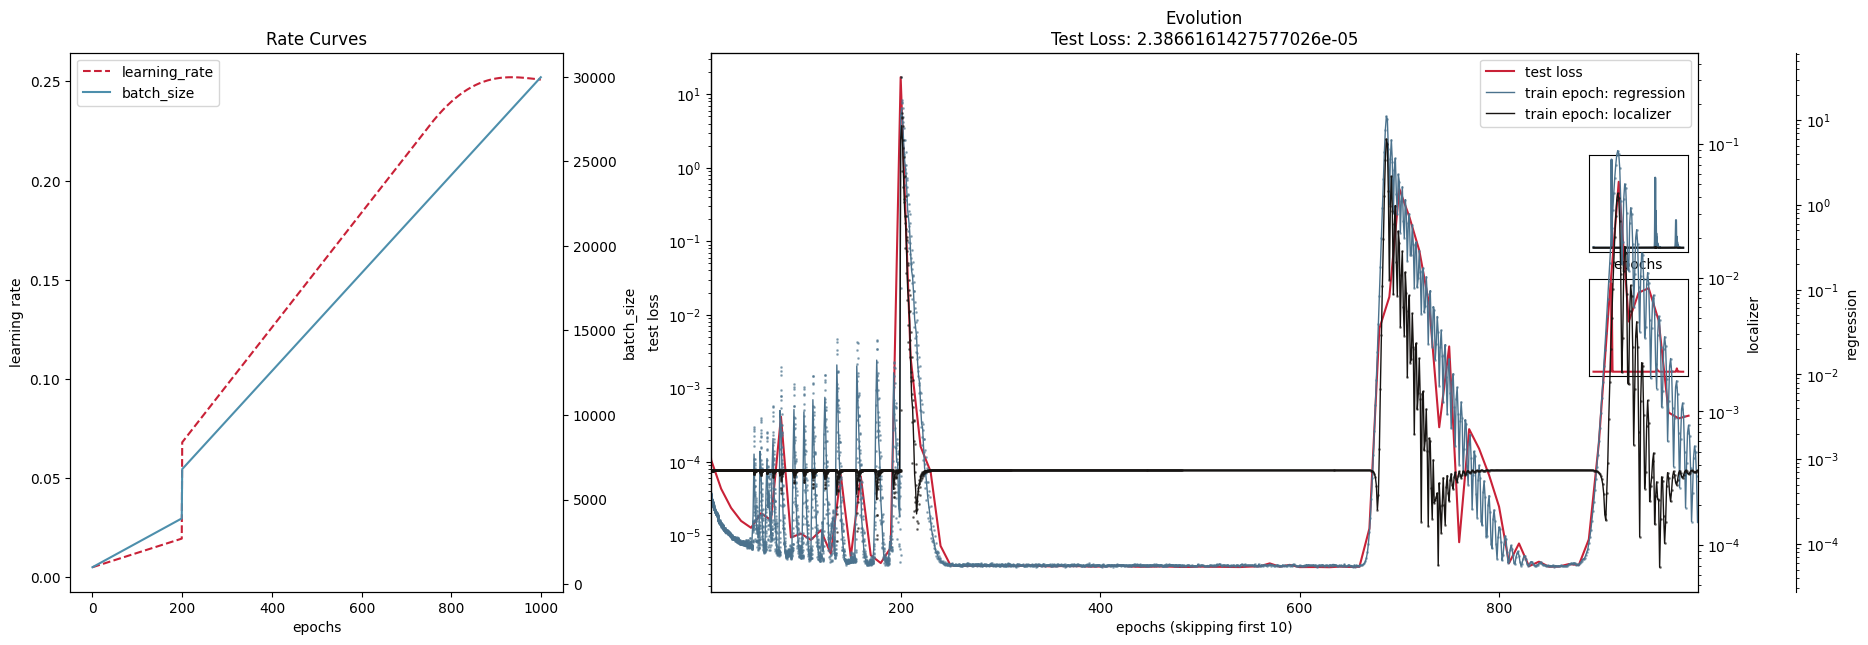

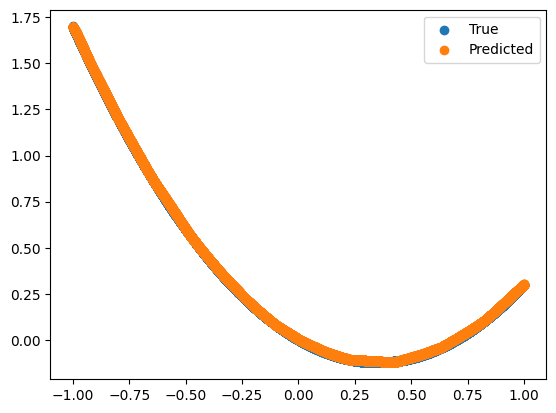

In [12]:
delta = np.array([1]*len(fl_sizes))*0.005
k = [ks[0]]*len(fl_sizes)
act = torch.nn.ReLU()
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:43<00:00, 22.89it/s]


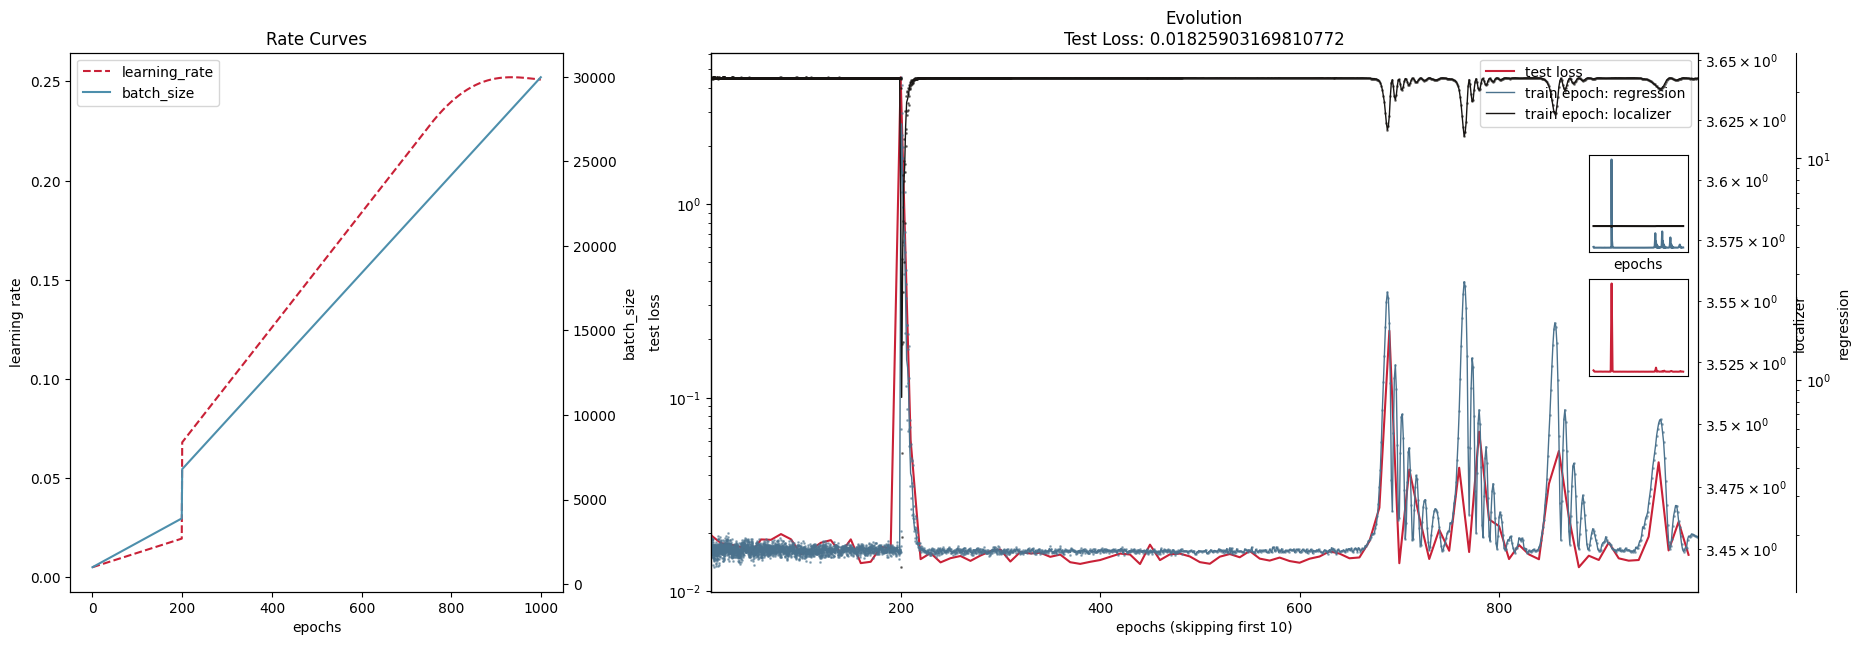

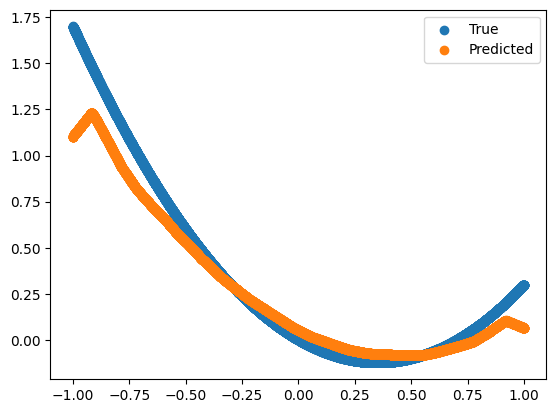

In [13]:
delta = np.array([1]*len(fl_sizes))*0.5
k = [ks[0]]*len(fl_sizes)
act = torch.nn.ReLU()
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

## FL 0 Greedy

100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


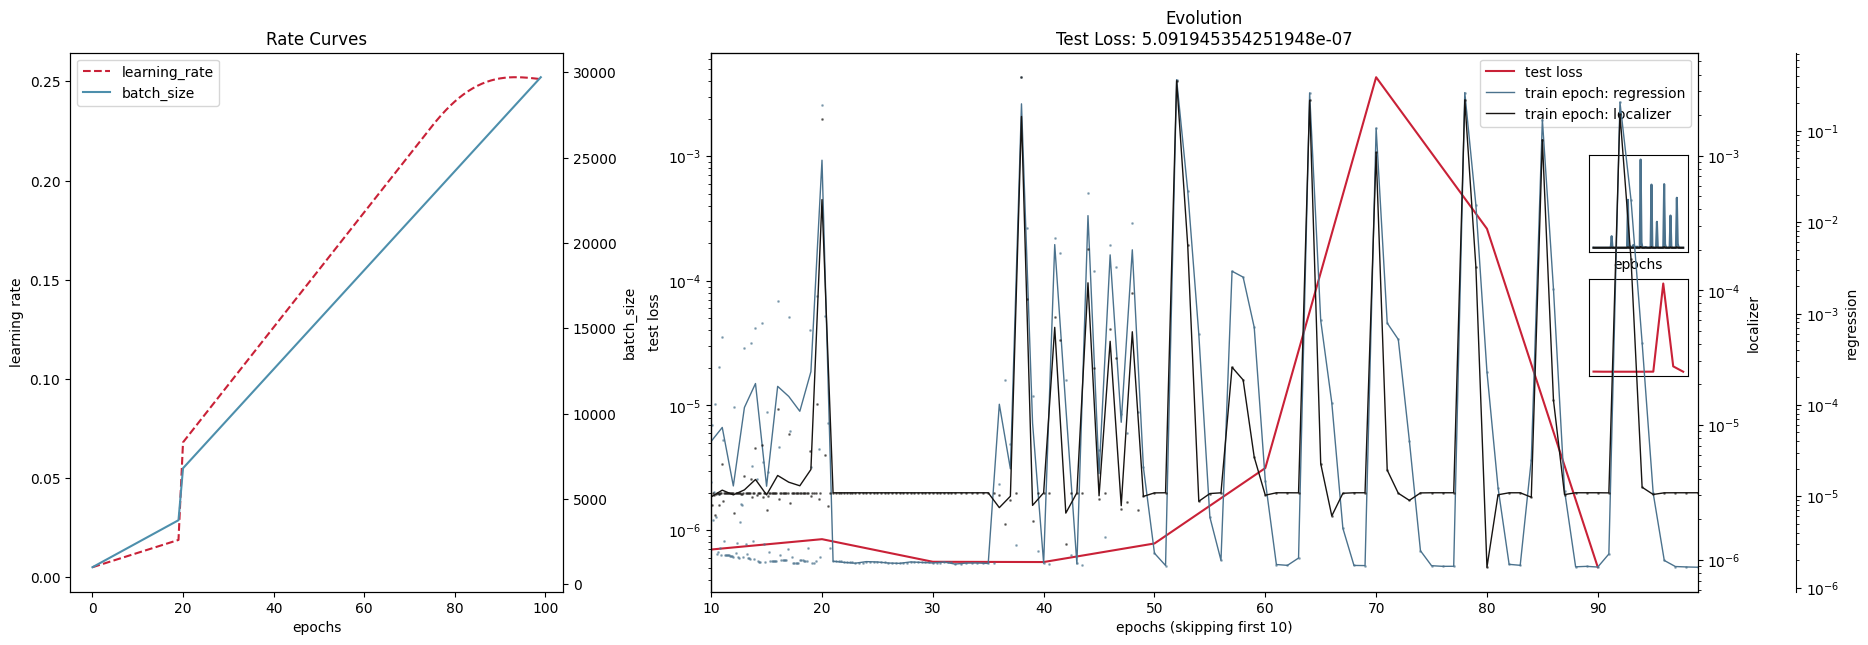

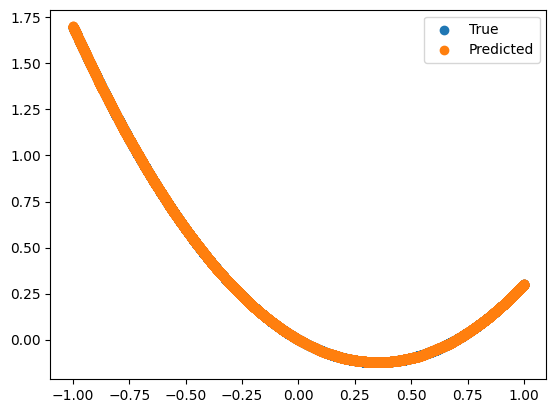

In [14]:
act = torch.nn.ReLU()
delta = np.array([1]*len(fl_sizes))*0.00005
k = [ks[1]]*len(fl_sizes)
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
D.epochs = 100
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000, repeat_epochs=40)
D.epochs = 1000
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

# Function 1

In [15]:
train_y, test_y = update_y(Ys1)

## DNN 1

100%|██████████| 1000/1000 [00:11<00:00, 85.92it/s]


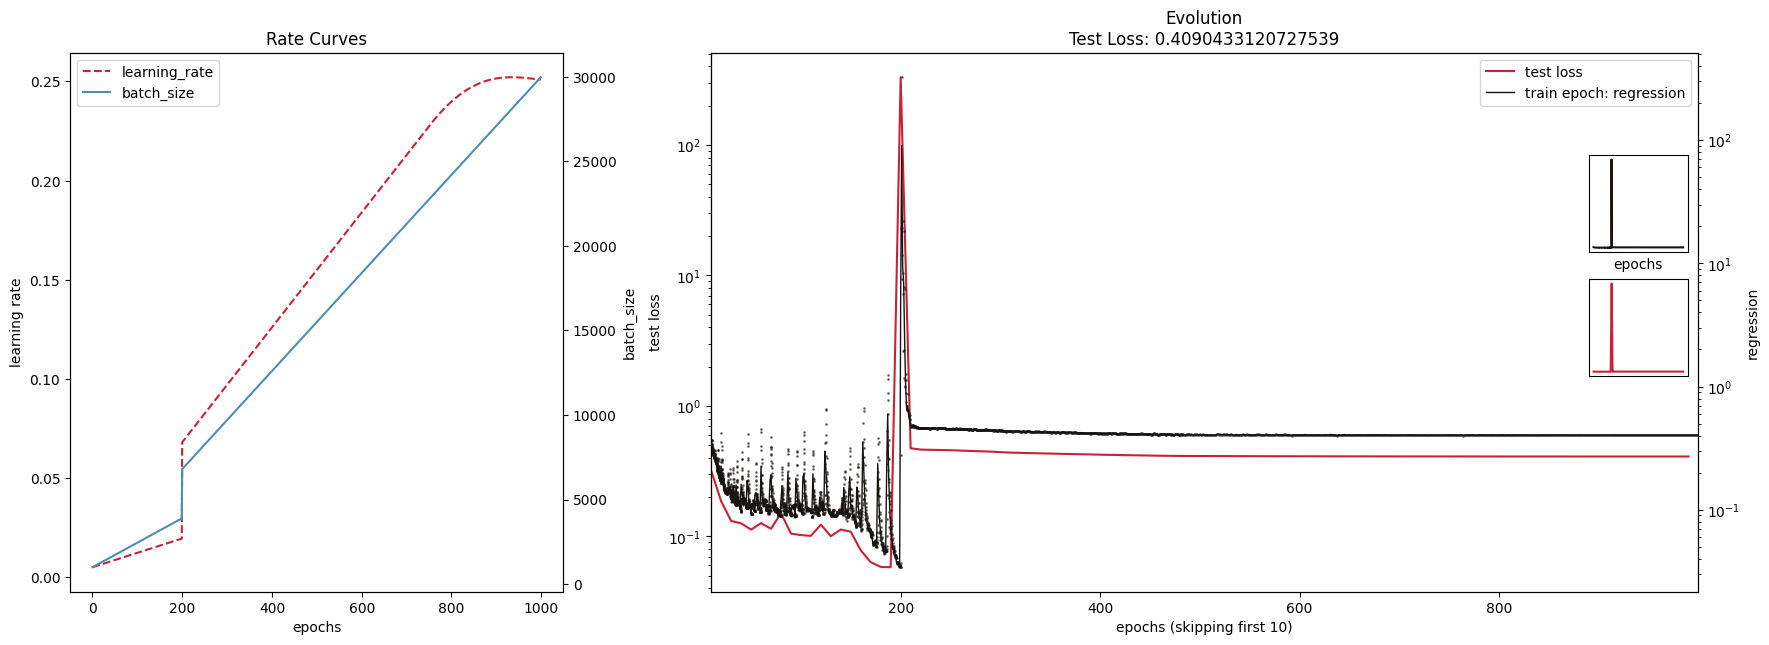

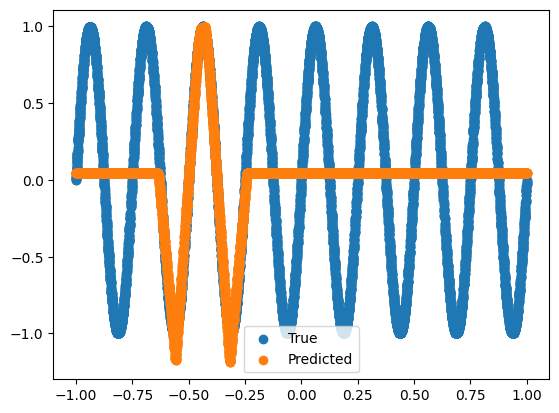

In [16]:
act = torch.nn.ReLU()
net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 10000/10000 [03:15<00:00, 51.10it/s]


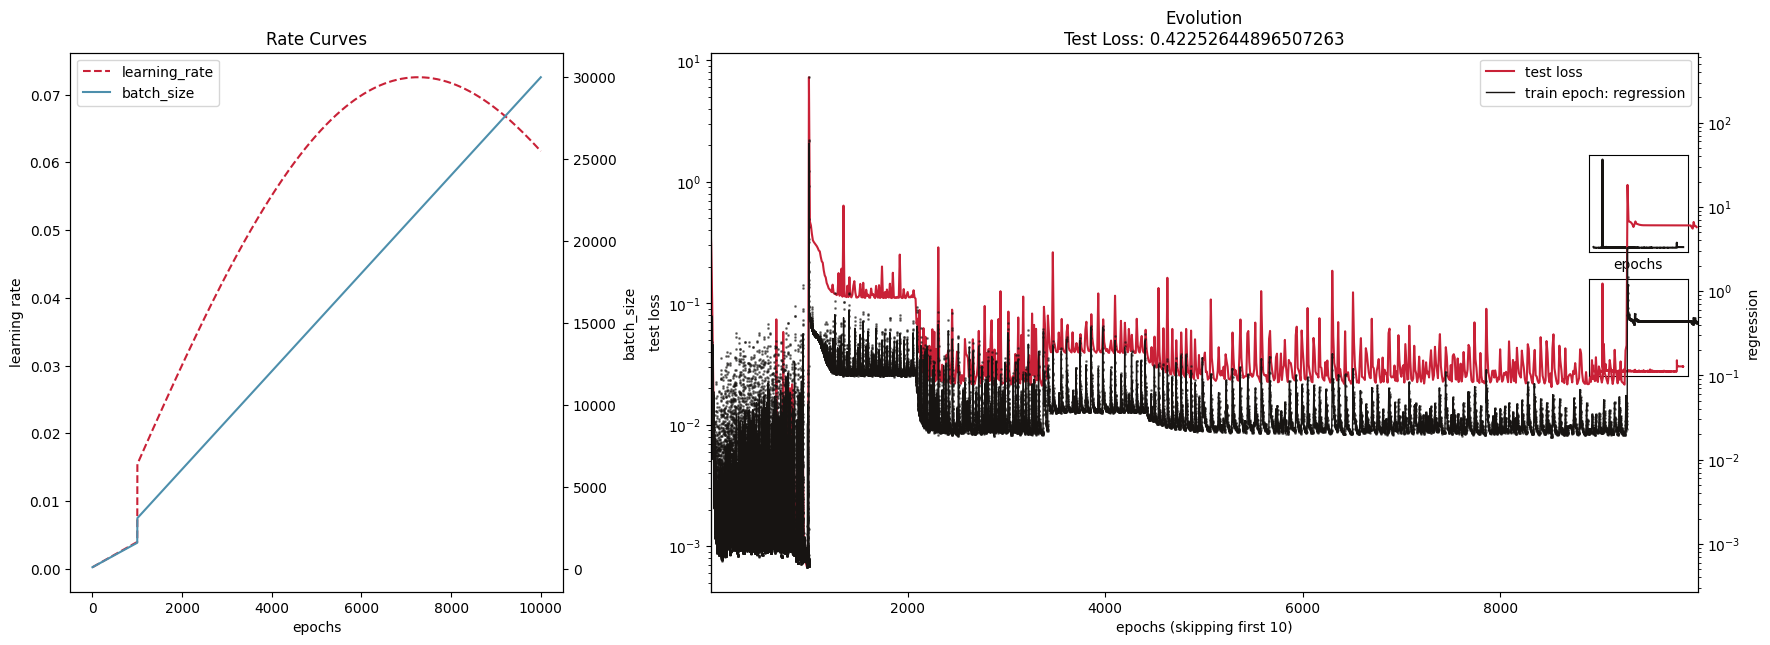

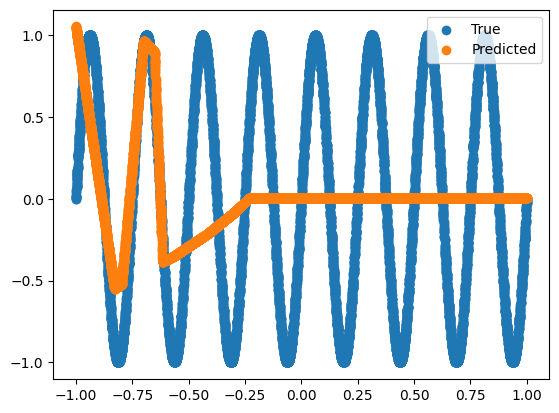

In [17]:
opt2 = lambda x: optim.Adam(x, lr=0.000005)
act = torch.nn.ReLU()
net = DNN(device, dnn_sizes, opttype=opt2, act = act, bias=True) # expect 1.6% error rate
D.epochs = 10000
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=100, max_batch_size=100, splits =[0.1,0.1], final_percent_lr=0.1)
D.epochs = 1000
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

## FL 1

100%|██████████| 1000/1000 [00:42<00:00, 23.80it/s]


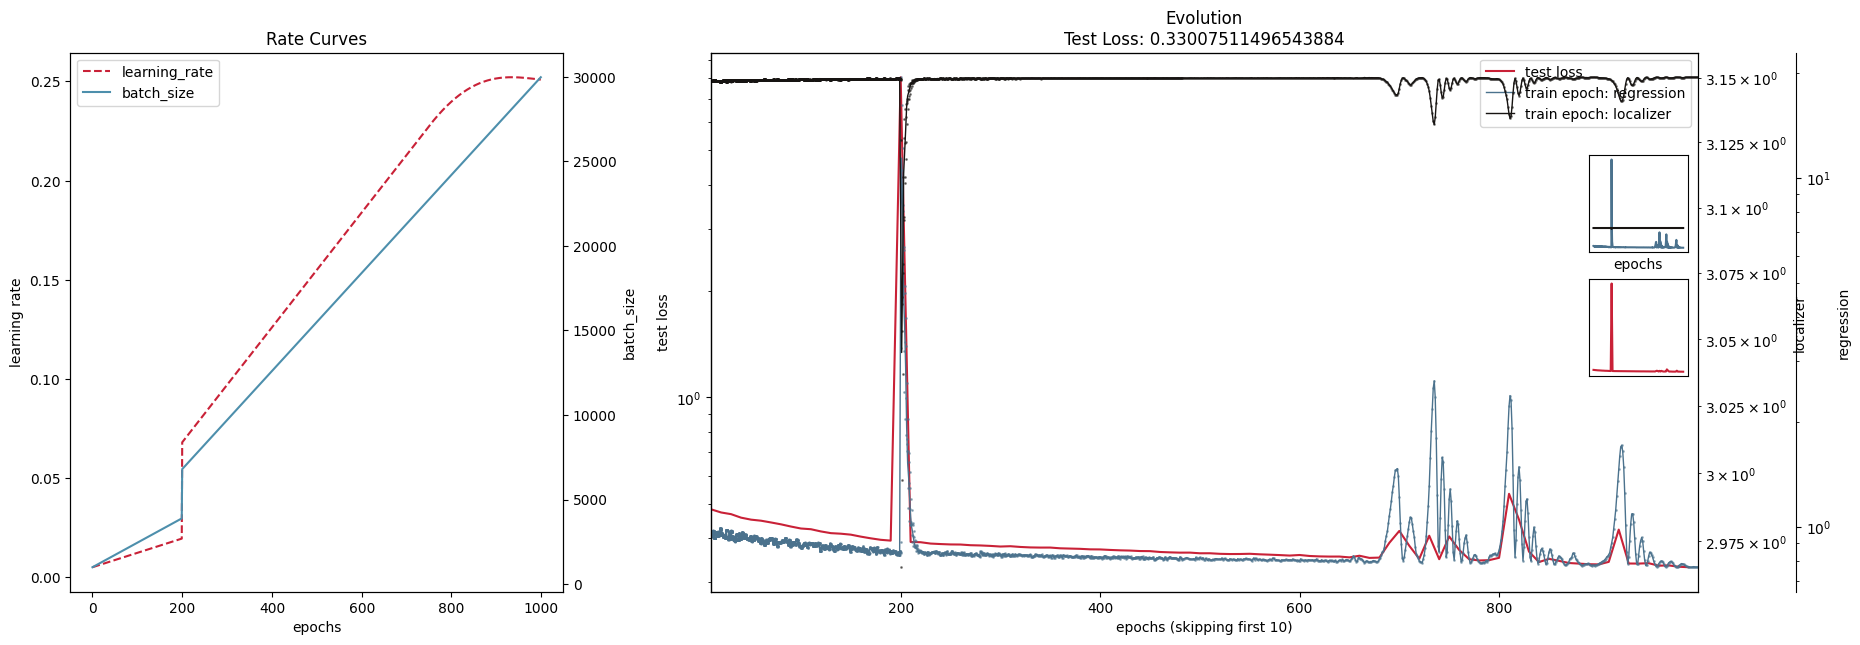

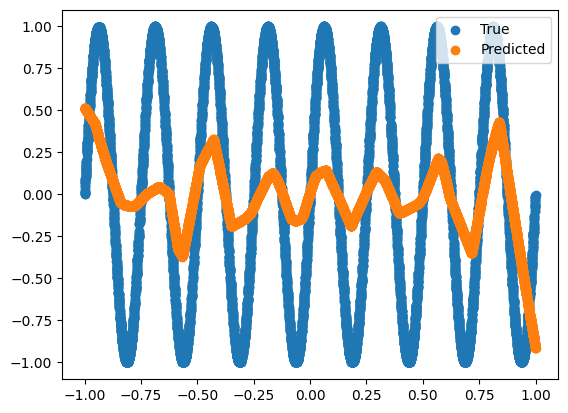

In [18]:
act = torch.nn.ReLU()
delta = np.array([1]*len(fl_sizes))*0.05
k = [ks[1]]*len(fl_sizes)
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:43<00:00, 23.15it/s]


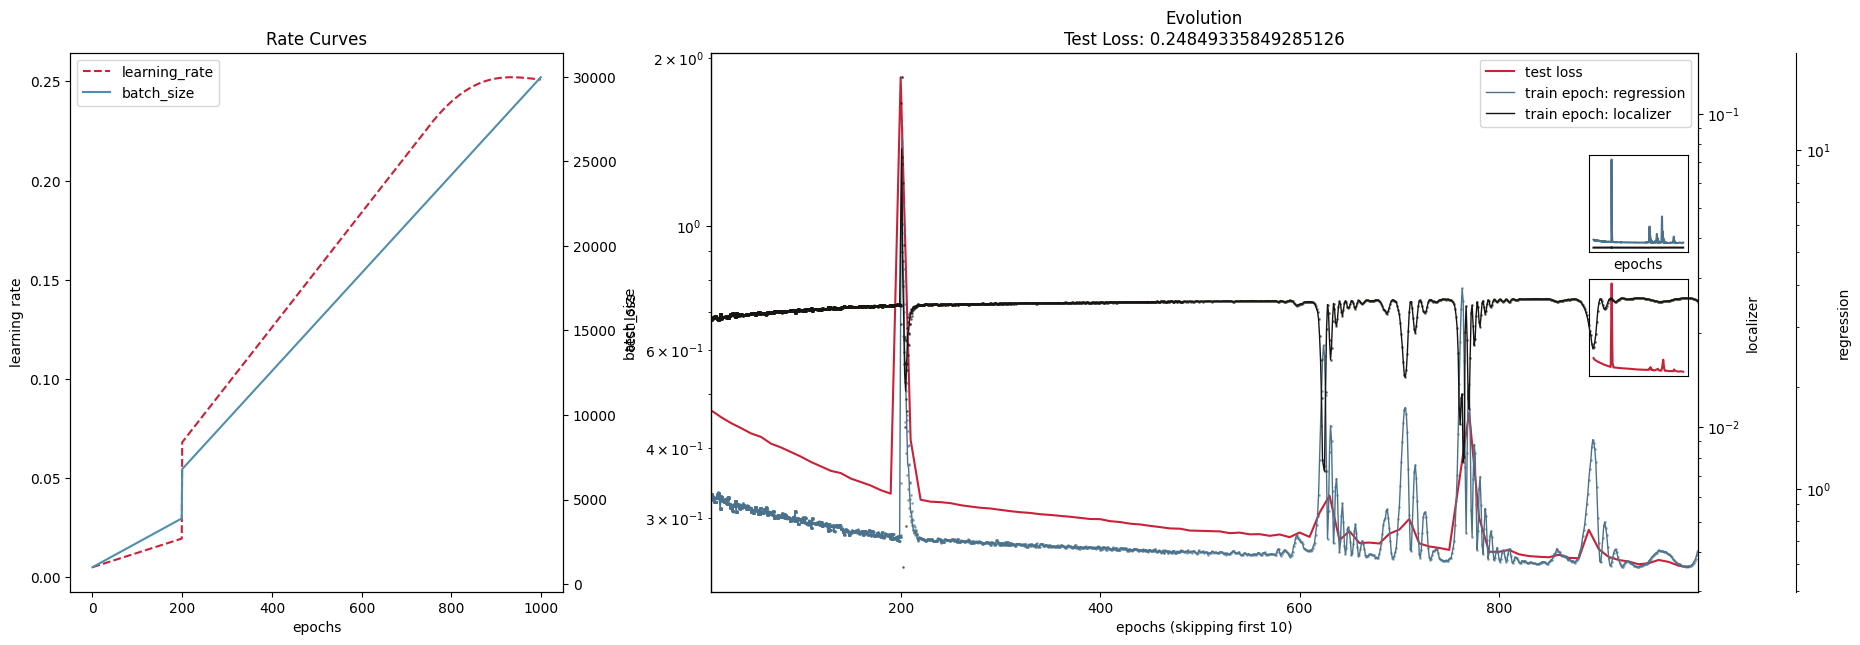

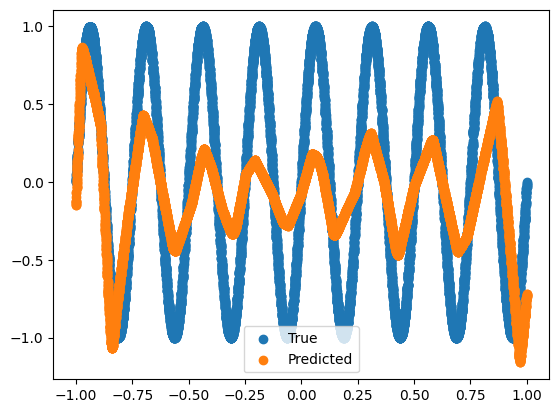

In [19]:
act = torch.nn.ReLU()
delta = np.array([1]*len(fl_sizes))*0.005
k = [ks[1]]*len(fl_sizes)
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:45<00:00, 21.94it/s]


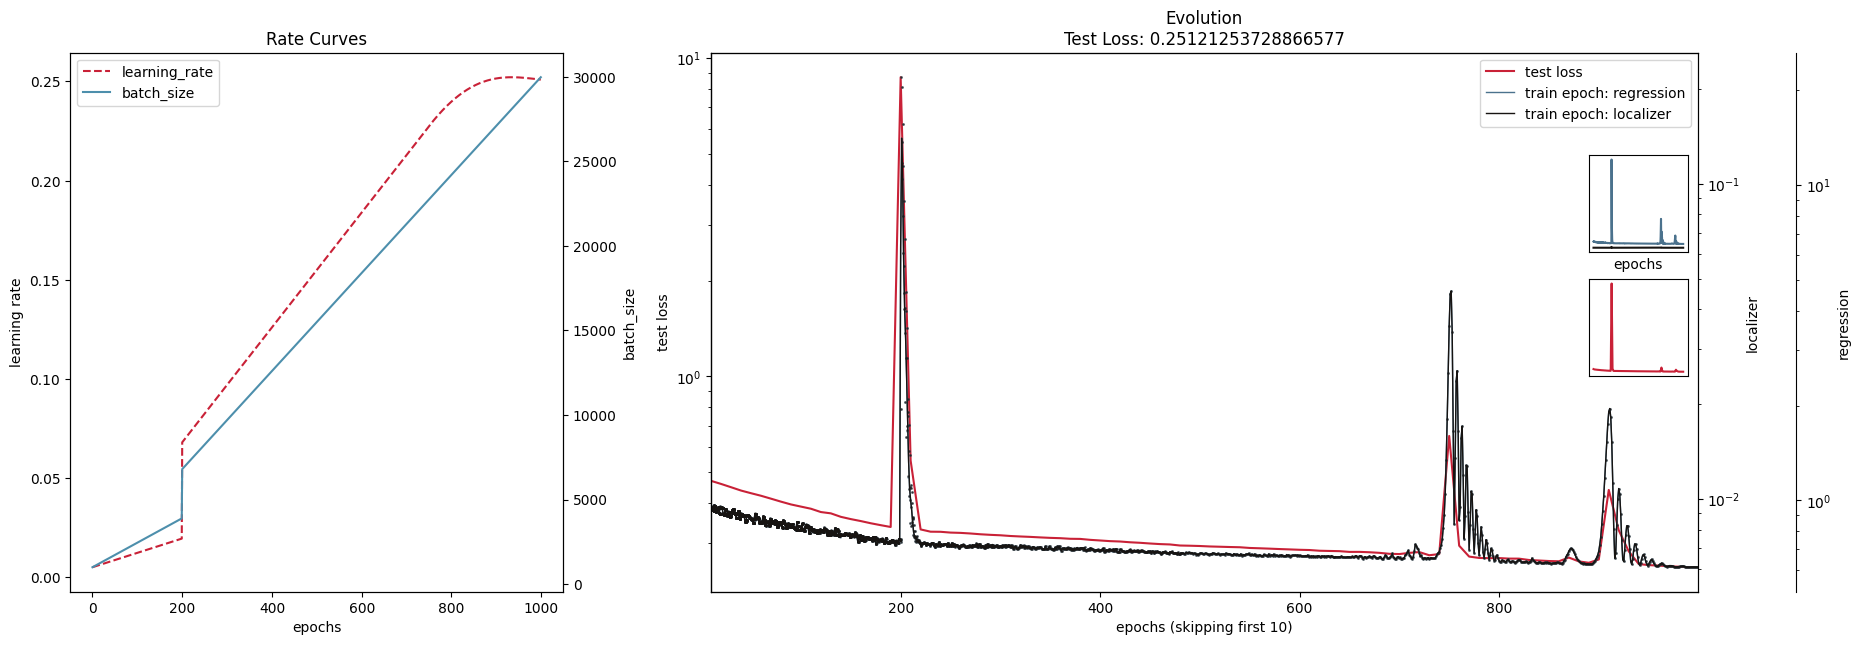

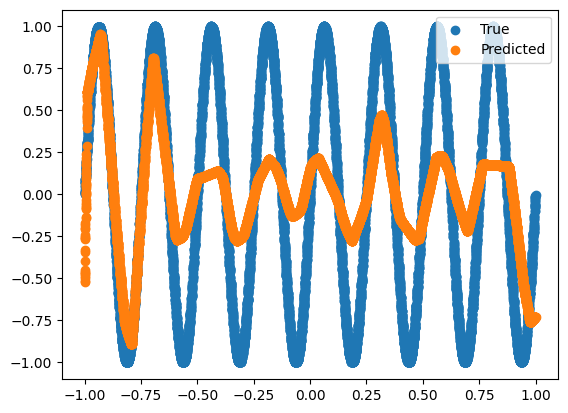

In [20]:
act = torch.nn.ReLU()
delta = np.array([1]*len(fl_sizes))*0.00005
k = [ks[1]]*len(fl_sizes)
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 4000/4000 [02:12<00:00, 30.12it/s]


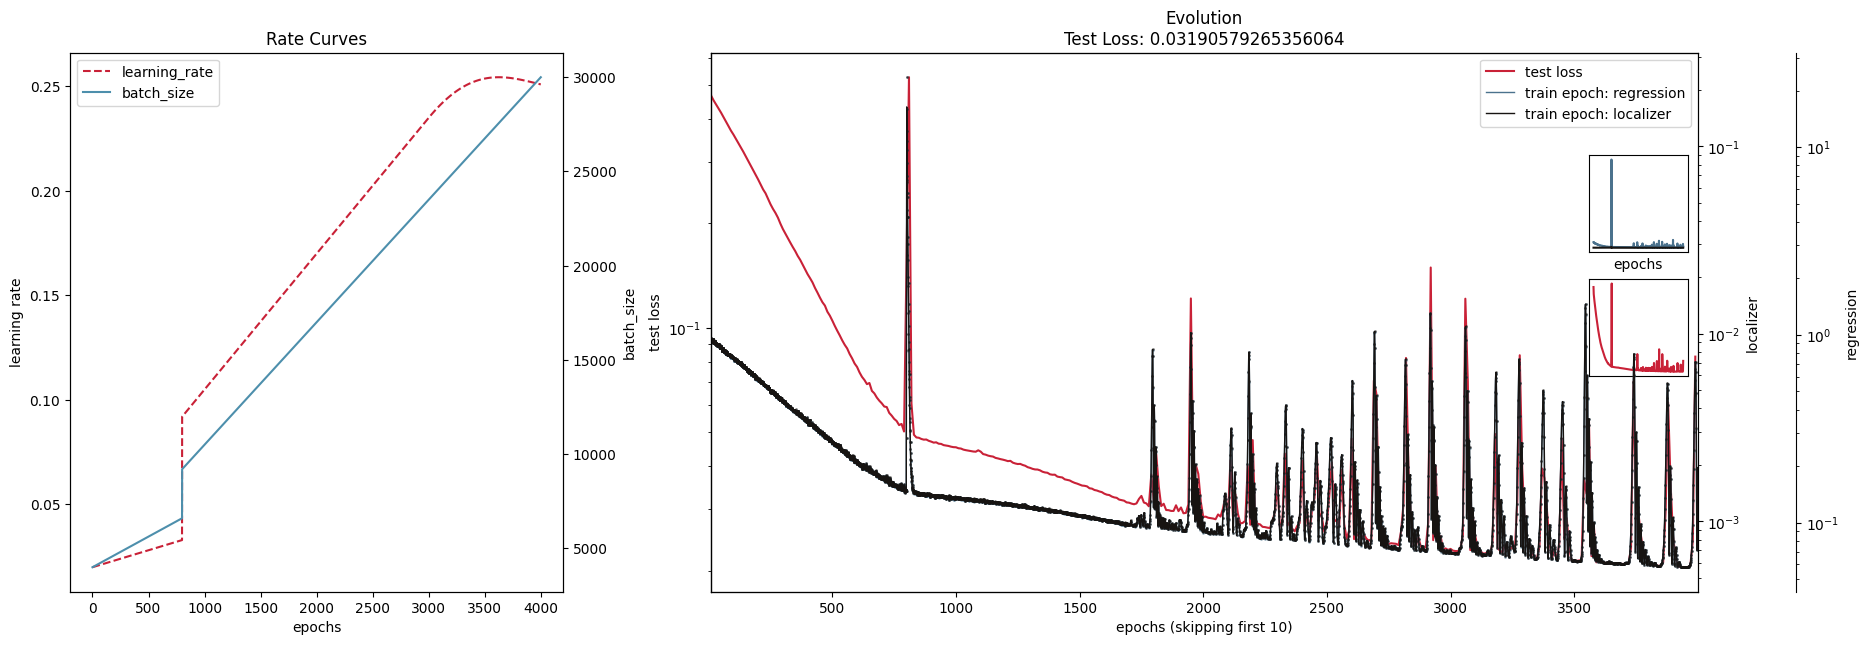

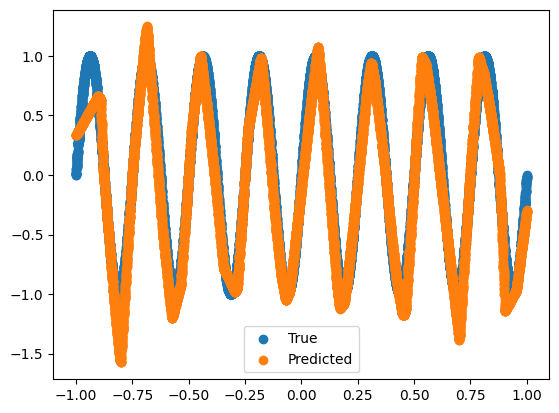

In [21]:
act = torch.nn.ReLU()
delta = np.array([1]*len(fl_sizes))*0.00005
k = [ks[1]]*len(fl_sizes)
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
D.epochs = 4000
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=4000)
D.epochs = 1000
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 4000/4000 [03:04<00:00, 21.71it/s]


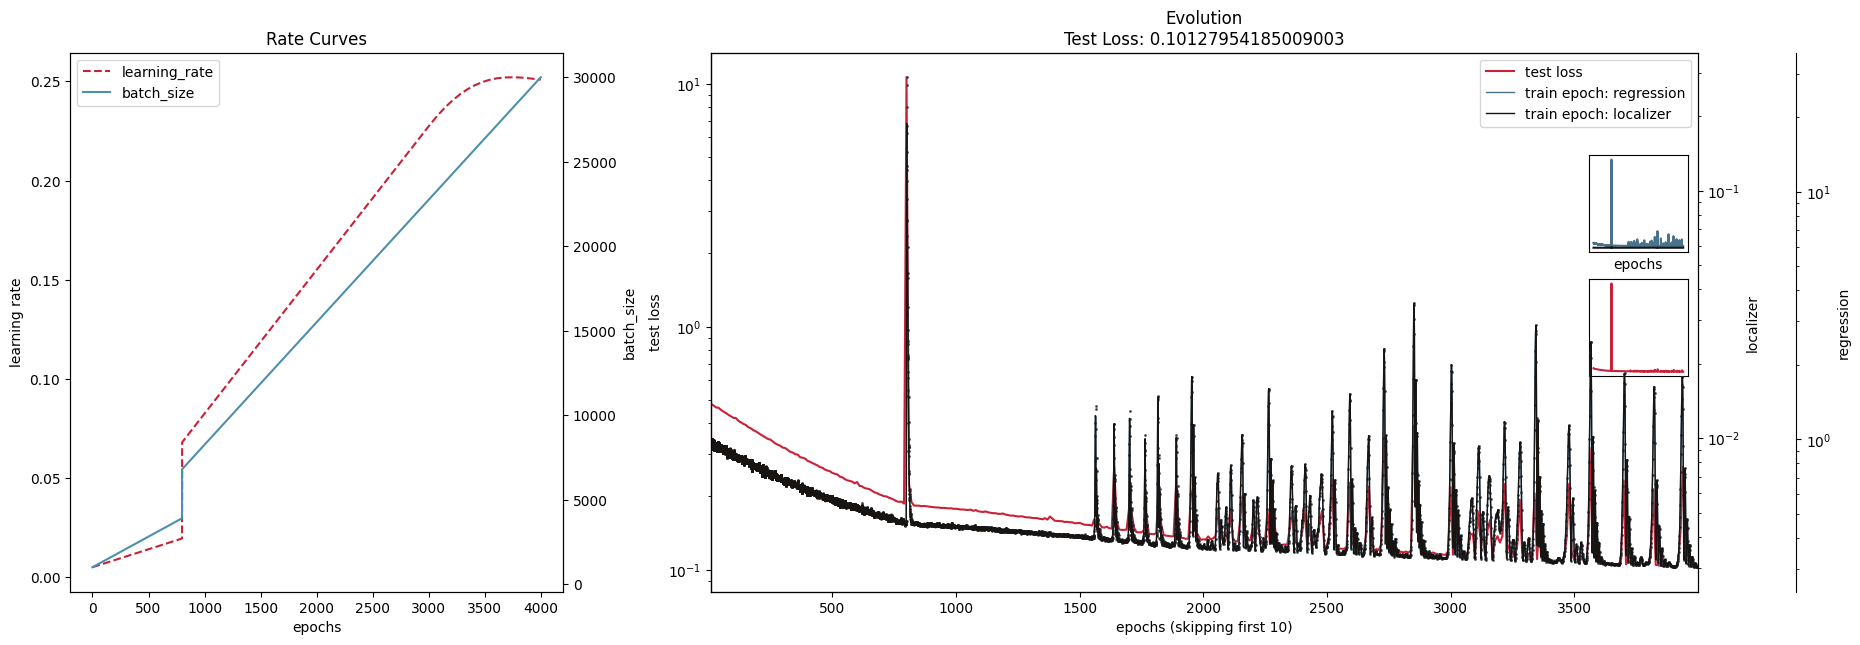

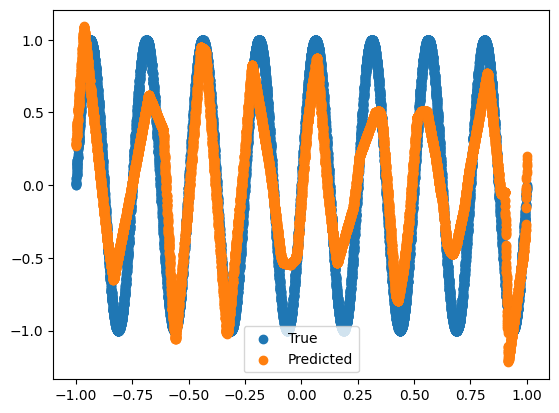

In [22]:
act = torch.nn.ReLU()
delta = np.array([1]*len(fl_sizes))*0.00005
k = [ks[1]]*len(fl_sizes)
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
D.epochs = 4000
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000)
D.epochs = 1000
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

## FL 1 Greedy

100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


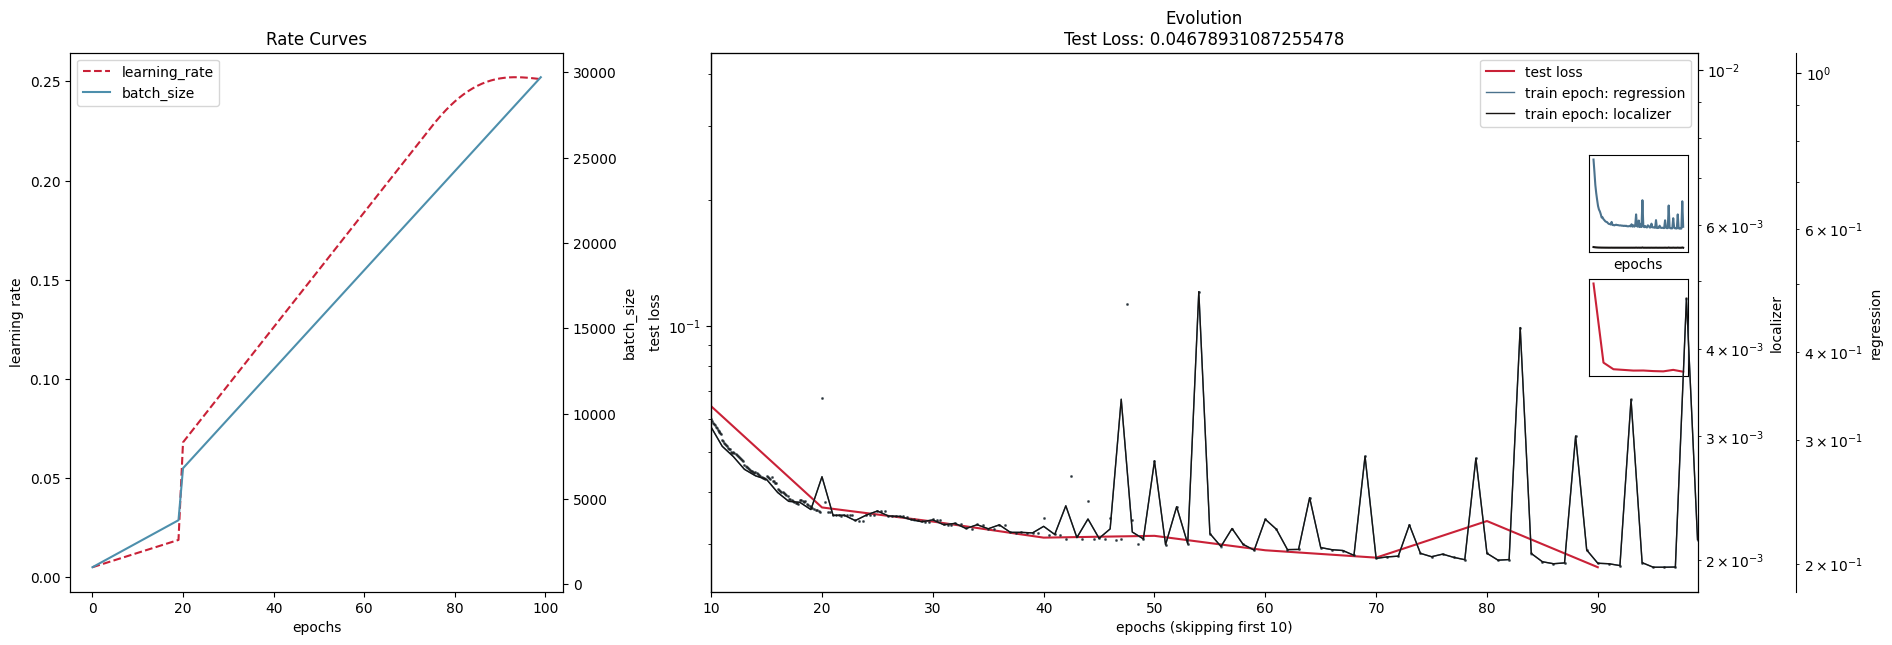

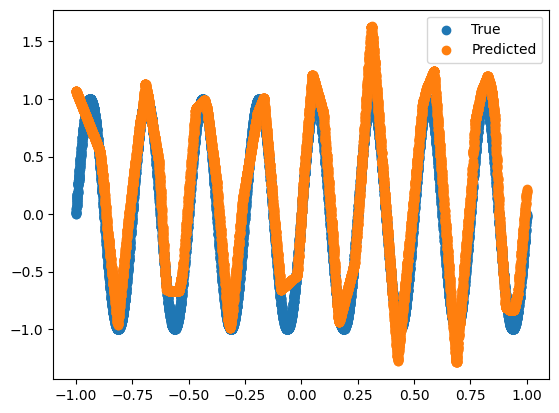

In [23]:
act = torch.nn.ReLU()
delta = np.array([1]*len(fl_sizes))*0.00005
k = [ks[1]]*len(fl_sizes)
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
D.epochs = 100
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000, repeat_epochs=40)
D.epochs = 1000
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

# Function 2

In [24]:
train_y, test_y = update_y(Ys2)

## DNN 2

100%|██████████| 1000/1000 [00:17<00:00, 55.89it/s]


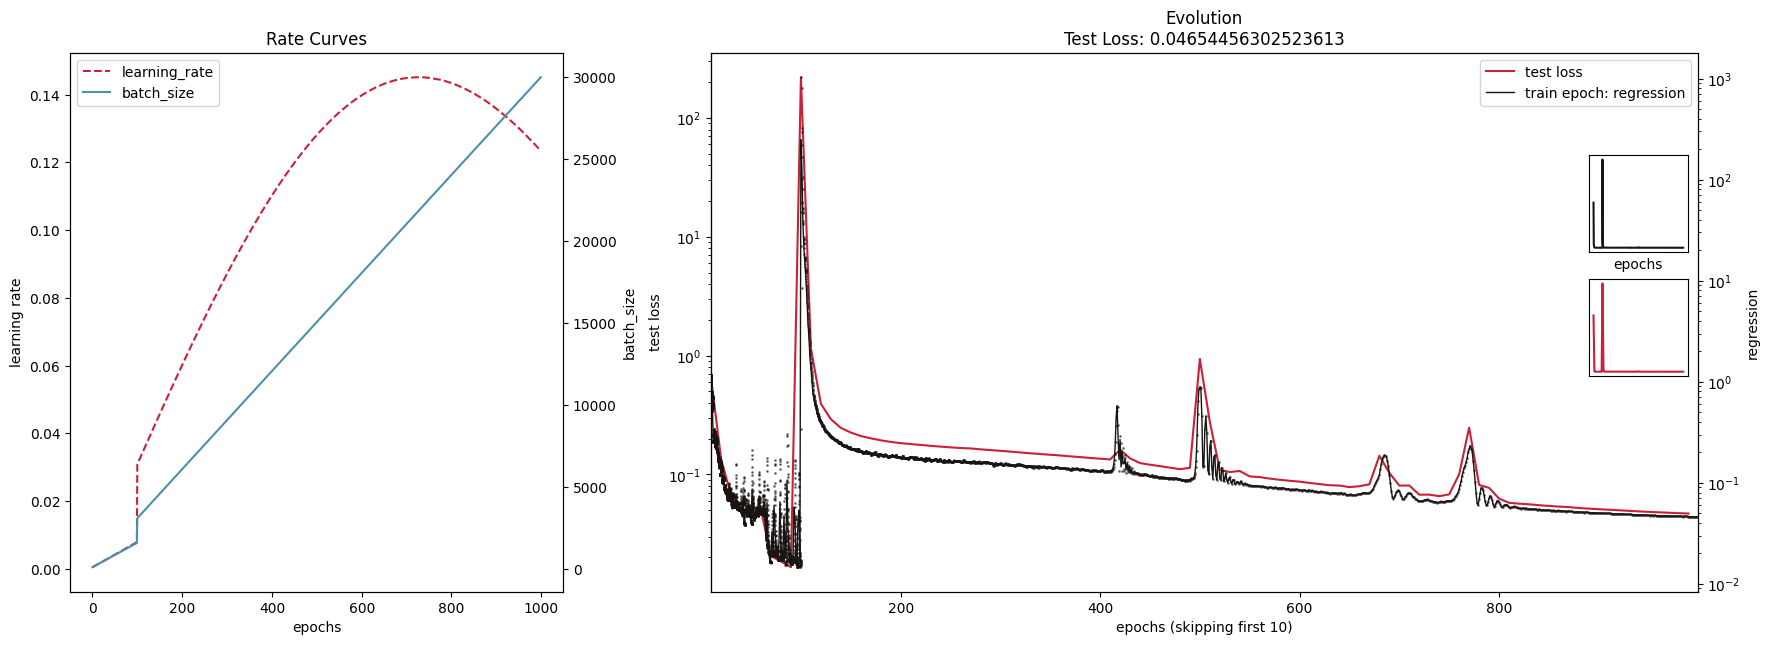

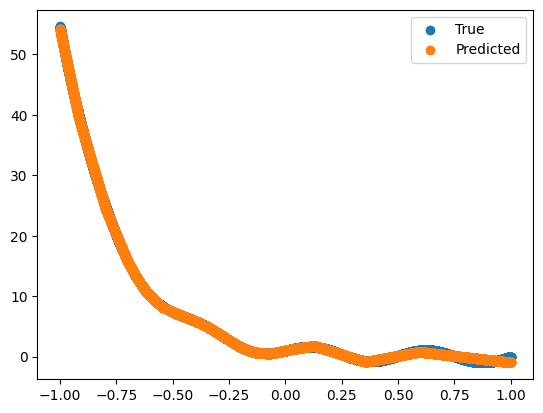

In [25]:
net = DNN(device, dnn_sizes2, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=100, max_batch_size=100, splits =[0.1,0.1], final_percent_lr=0.1)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:22<00:00, 44.51it/s]


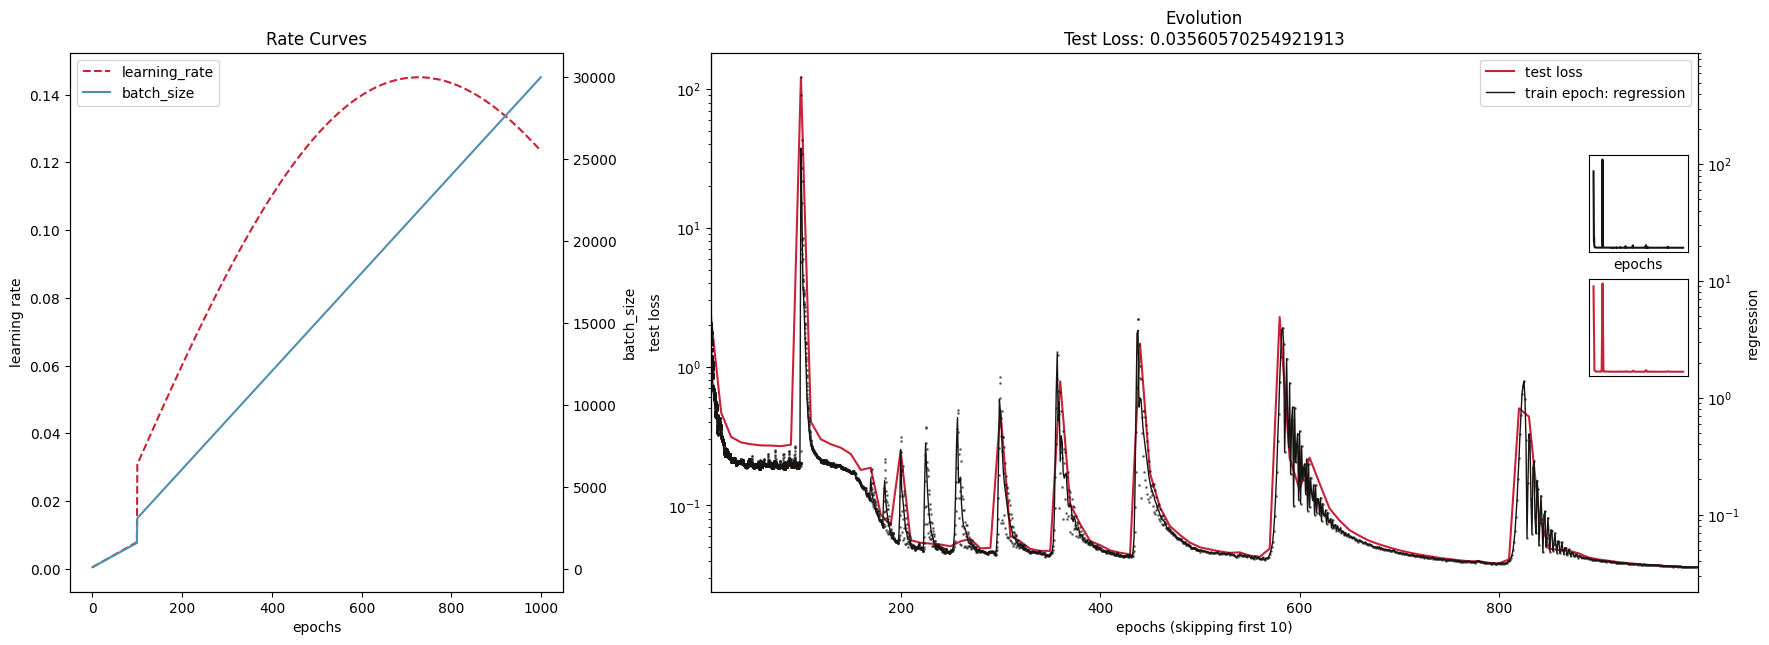

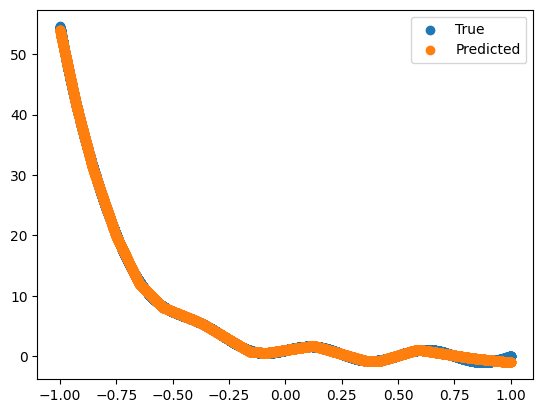

In [26]:
net = DNN(device, dnn_sizes2, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=100, splits =[0.1,0.1], final_percent_lr=0.1)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 500/500 [00:02<00:00, 216.71it/s]


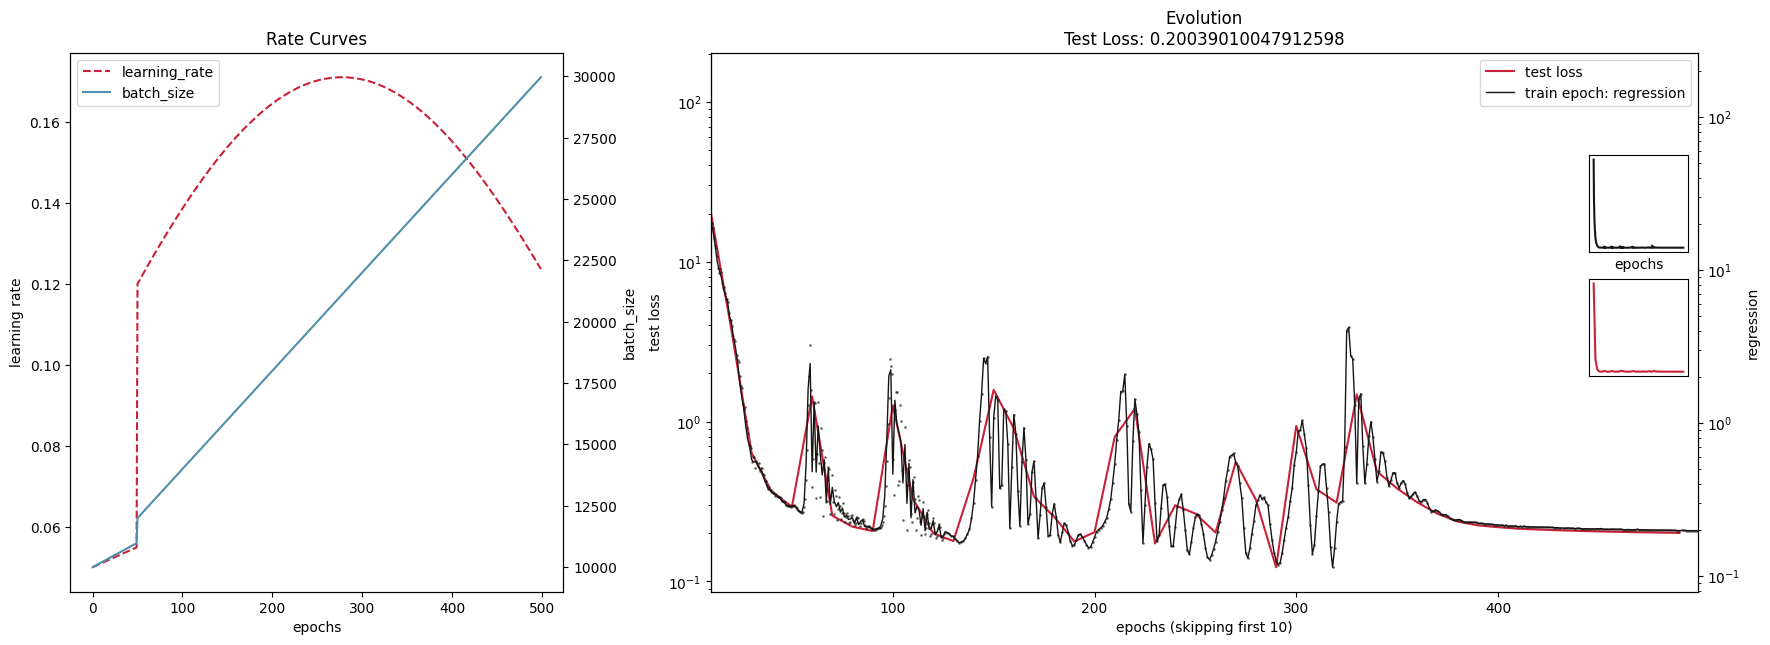

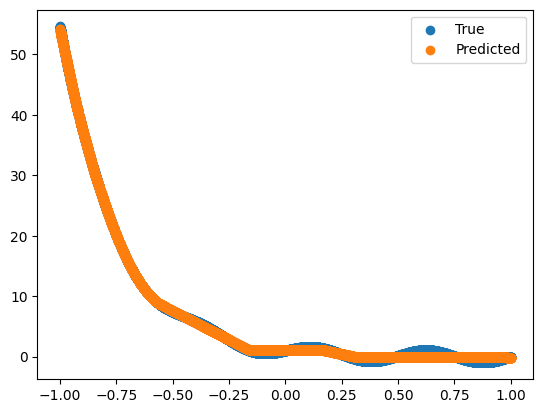

In [27]:
net = DNN(device, dnn_sizes2, opttype=opt, act = act, bias=True) # expect 1.6% error rate
D.epochs=500
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000, splits =[0.1,0.1], final_percent_lr=0.1)
D.epochs=1000
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

## FL 2

100%|██████████| 1000/1000 [00:46<00:00, 21.69it/s]


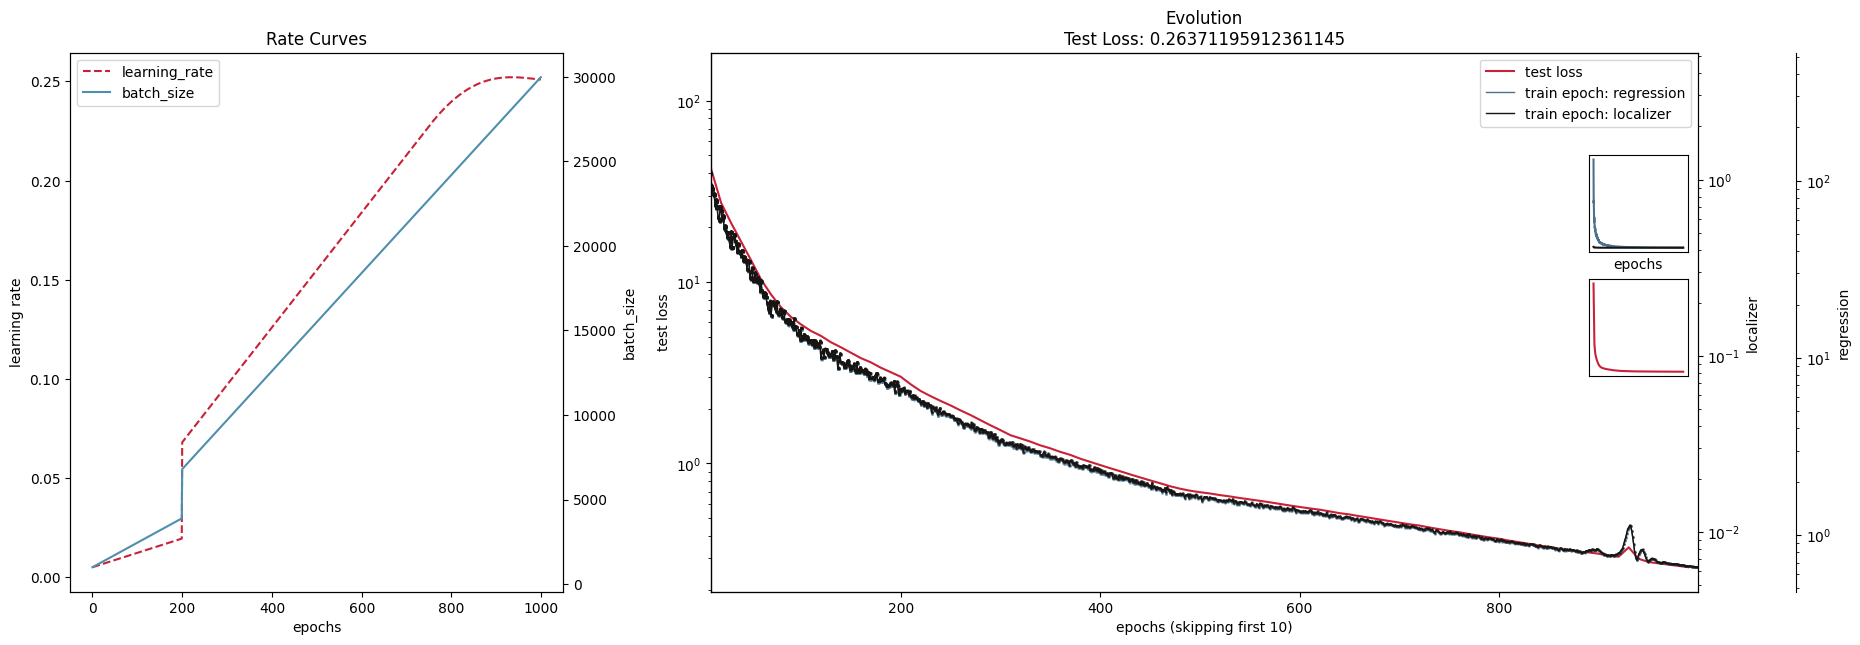

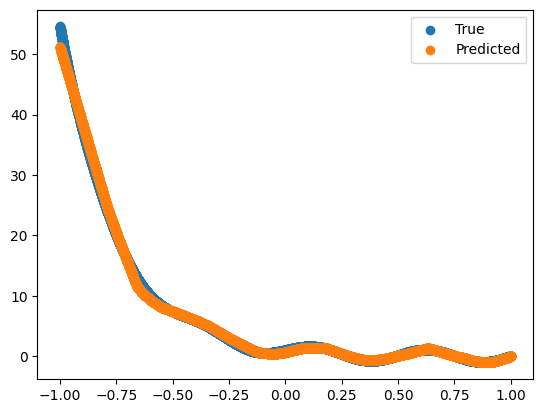

In [28]:
act = torch.nn.ReLU()
delta = np.array([1]*len(fl_sizes))*0.00005
k = [ks[2]]*len(fl_sizes)
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:45<00:00, 22.21it/s]


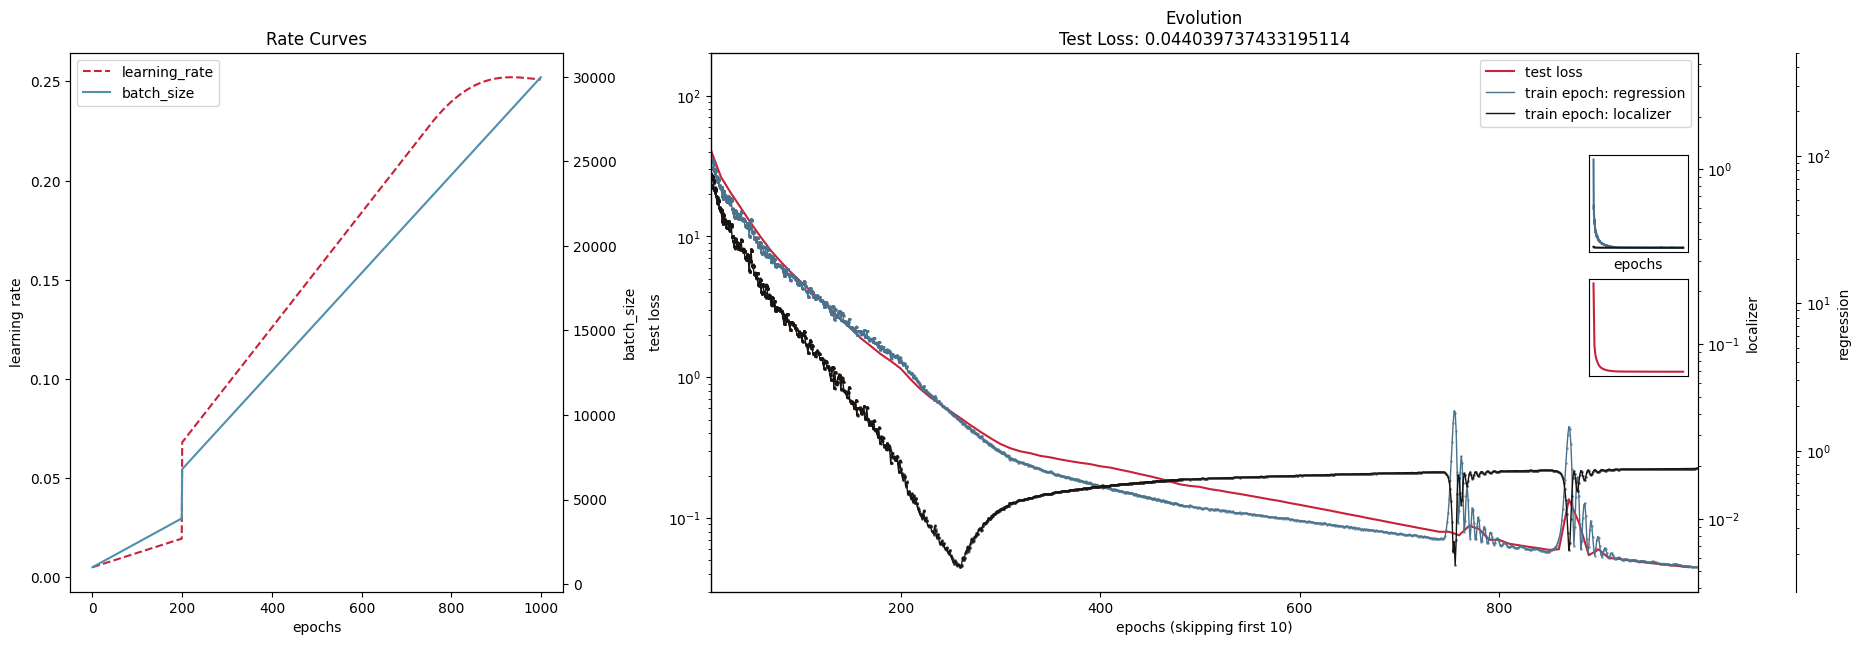

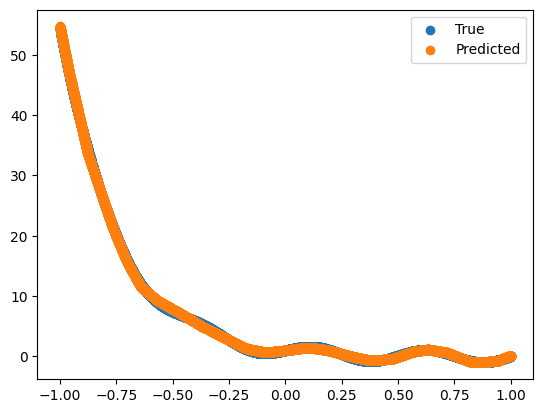

In [29]:
act = torch.nn.ReLU()
delta = np.array([1]*len(fl_sizes))*0.0005
k = [ks[2]]*len(fl_sizes)
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 500/500 [00:14<00:00, 33.68it/s]


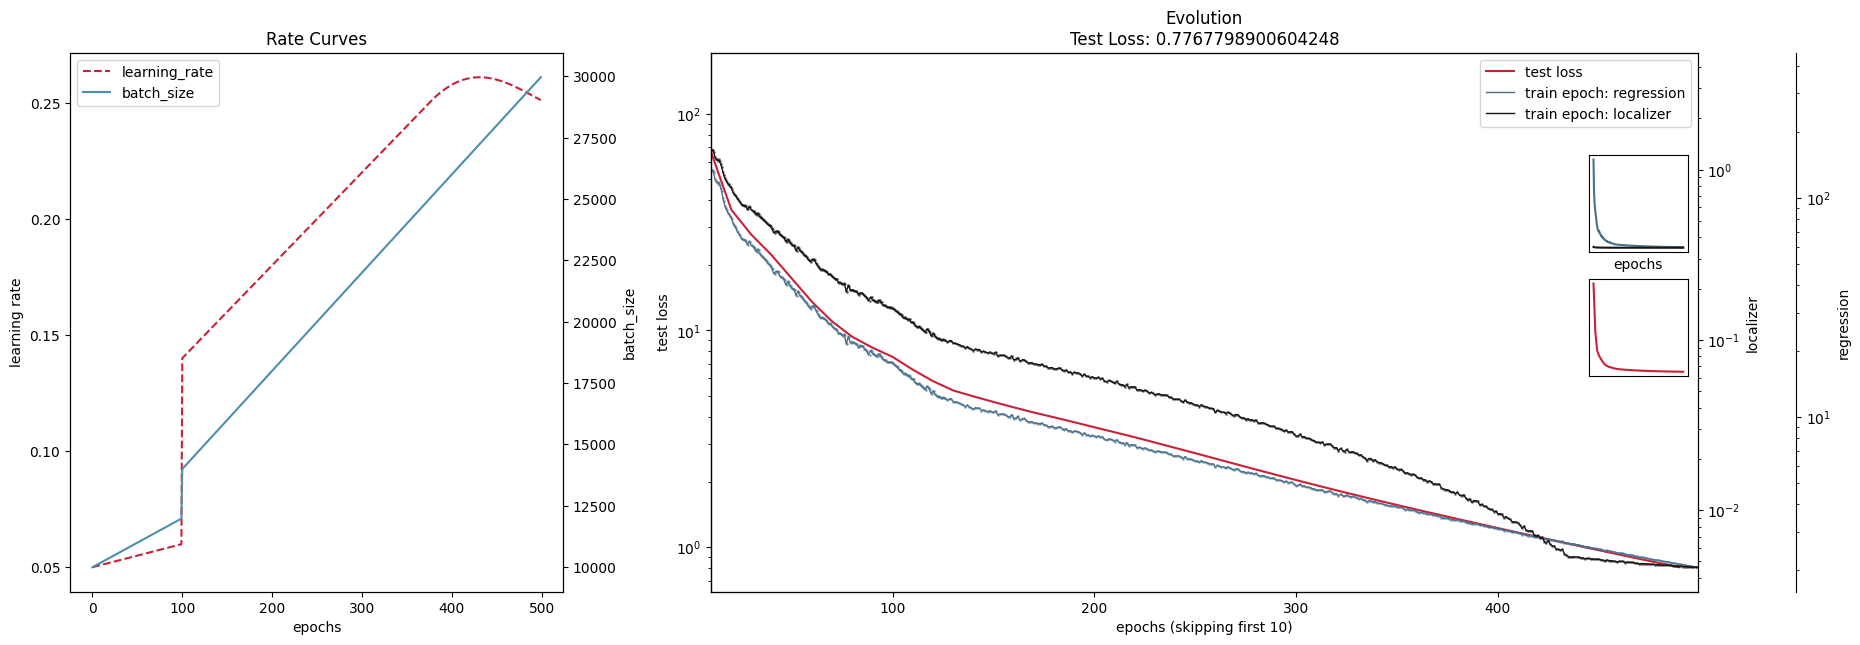

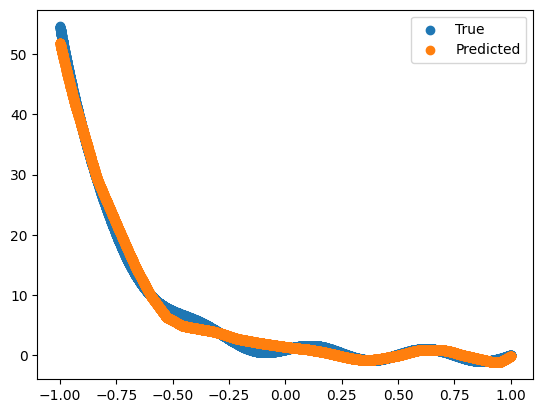

In [30]:
act = torch.nn.ReLU()
delta = np.array([1]*len(fl_sizes))*0.0005
k = [ks[2]]*len(fl_sizes)
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
D.epochs = 500
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000)
D.epochs = 1000
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

## FL 2 Greedy

100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


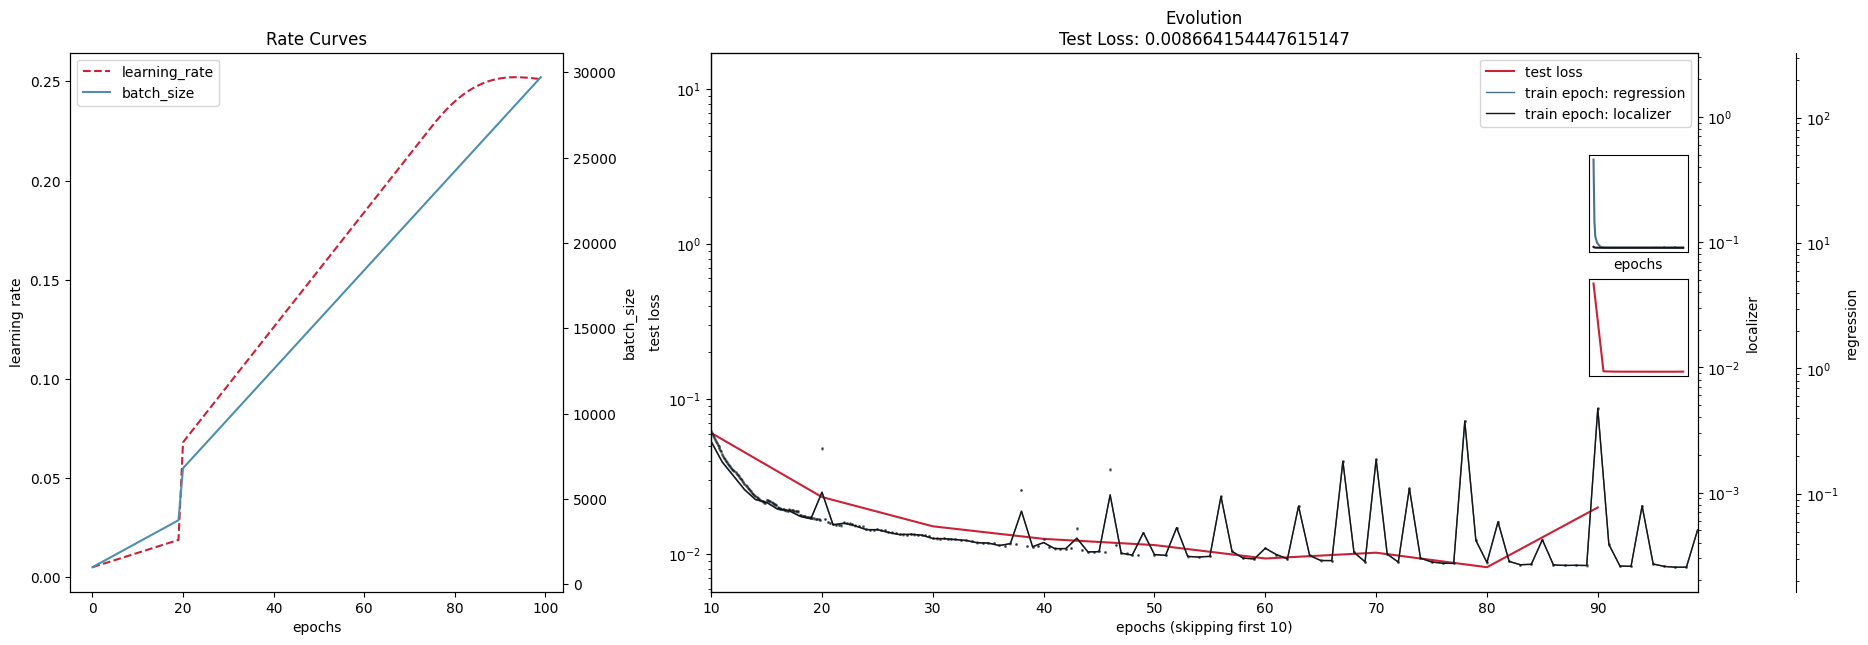

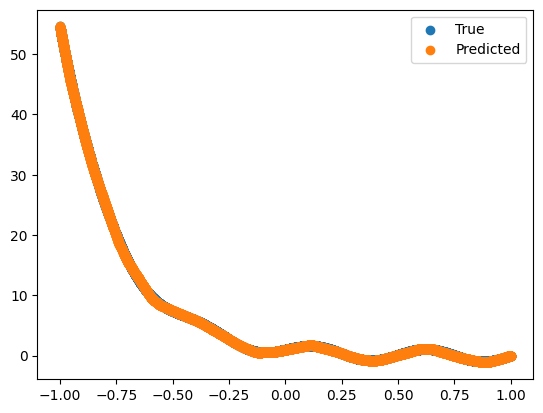

In [31]:
act = torch.nn.ReLU()
delta = np.array([1]*len(fl_sizes))*0.00005
k = [ks[1]]*len(fl_sizes)
net = FL(device, fl_sizes, delta, k, opttype=opt, act = act, bias=True) # expect 1.6% error rate
D.epochs = 100
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=1000, repeat_epochs=40)
D.epochs = 1000
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()